In [1]:
import seaborn as sns
from process_model import *
from scipy.stats import norm
from scipy.stats import binom

from chase.base import *
from chase.utils import *
from chase.fit import *
sns.set_style("whitegrid")
import itertools
import pickle
from process_recovery import *

PARS = {'theta': [1, 5],
        'c': [.01, 2, .5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],
        'sc': [0, 10, 1],
        'k': [0, 5, 1],
        'sep': [0, 5, 1]}

FIGDEST = '/Users/markant/code/chase/chase/paper/results_figures'
TABDEST = '/Users/markant/code/chase/chase/paper/results_tables'
OUTDIR = 'results_fits/chase_fitresults_process'

In [3]:
problems = {}
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
for i in range(len(arr)):
    problems[i] = arr[i].reshape((2,2,2))

In [28]:
# normal
problems = {1: generate_normal_problem([[1, .5], [1.5, .5]], n_x=50)}

In [5]:
HBWE_PROBLEMS = {}
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
for i in range(len(arr)):
    HBWE_PROBLEMS['6p-%s' % i] = arr[i].reshape((2,2,2))

In [ ]:
NORMAL_PROBLEMS = {'normal_high_diff': [[[1, .1], [10, .1]]],
                   'normal_low_diff': [[[1, .1], [2, .1]]]}

# Plot example trajectories

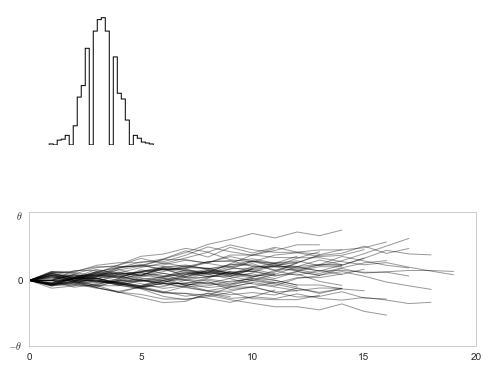

In [62]:
pid = 1
tr = traces[pid]
th = threshold[pid]

fig, axi = plt.subplots(2, 1, figsize=(8, 6))

bins = np.bincount(np.array(ss[pid], int)).shape[0]

ax = axi[0]
sns.distplot(ss[pid], hist=True, kde=False, bins=bins, ax=ax, color='black',
             hist_kws={"histtype": "step", "linewidth": 1,
                       "alpha": 1, "color": 'black'})
ax.set_xlim(0,90)
ax.axis('off')

ax = axi[1]
for trace in tr[:50]:
    ax.plot(trace, color='black', alpha=.4, linewidth=1)
#ax.plot([0,140], [threshold,threshold], '-', color='black')
#ax.plot([0,140], [-threshold,-threshold], '-', color='black')

ax.set_yticks([-th, 0, th])
ax.set_yticklabels([r'$-\theta$', 0, r'$\theta$'])
ax.grid(False)
#ax.set_ylim(-th, th)
plt.show()
fig.savefig(FIGDEST+'example_trajectories_fixed.pdf', bbox_inches='tight')

In [63]:
from scipy.stats import norm

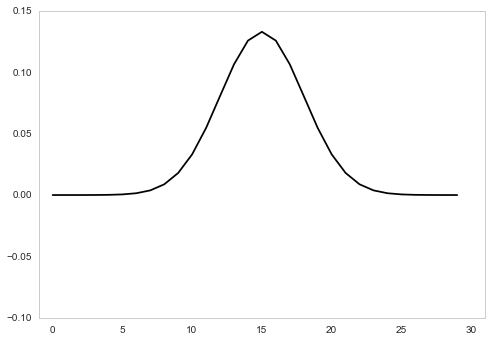

In [79]:
fig, ax = plt.subplots()
ax.plot([norm.pdf(x, loc=15, scale=3) for x in range(30)], '-', color='black')
ax.grid(False)
ax.set_xlim(-1, 31)
ax.set_ylim(-.1, .15)
plt.show()
fig.savefig(FIGDEST+'normal.pdf', bbox_inches='tight')

In [5]:
m = CHASEModel(drift='cpt',
               startdist='laplace', 
               problems=problems)

In [6]:
res = m(problems[1], {'p_stay': .3, 'tau': .1, 'theta': 10, 'dt': 1, 'max_T': 300})

In [12]:
res['p_stop_cond'].shape

(300, 2)

In [24]:
pr = res['p_stop_cond'][:,1]/res['p_stop_cond'][:,1].sum()
samp = np.random.choice(range(300), 10000000, p=pr)

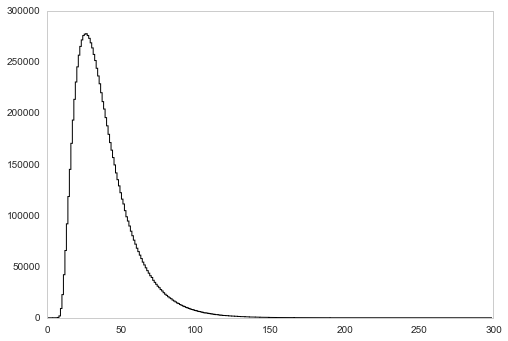

In [26]:
fig, ax = plt.subplots()
sns.distplot(samp, hist=True, kde=False, bins=range(300), color='black', ax=ax,
             hist_kws={"histtype": "step", "linewidth": 1,
                       "alpha": 1, "color": 'black'})
ax.grid(False)
plt.show()
fig.savefig(FIGDEST+'pred_distribution.pdf', bbox_inches='tight')

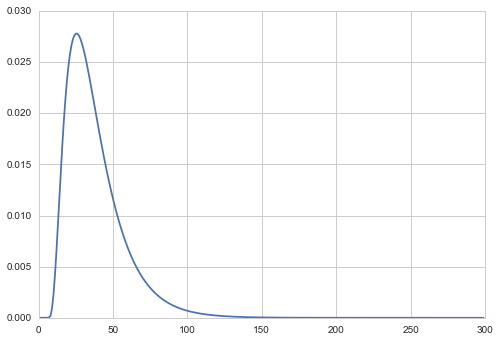

In [7]:
plt.plot(res['p_stop_cond'][:,1])

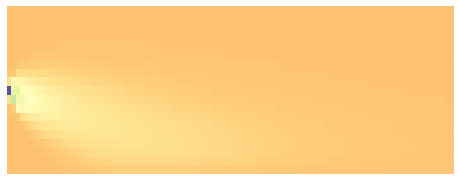

In [133]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(res['states_t'].transpose()-.2, cbar=False, ax=ax, cmap="Spectral")
ax.set_xticks([])
ax.set_yticks([])
plt.show()
fig.savefig(FIGDEST+'statespace.pdf', bbox_inches='tight')

In [350]:
from chase.initial_distribution import laplace_initial_distribution
from scipy.stats import laplace

In [356]:
theta = 5
Z = laplace_initial_distribution(2*theta+1, {'tau': .5, 'theta': theta})


In [351]:
xs = np.arange(-5, 5)
laplace.pdf(xs, loc=0, scale=1)

array([ 0.00336897,  0.00915782,  0.02489353,  0.06766764,  0.18393972,
        0.5       ,  0.18393972,  0.06766764,  0.02489353,  0.00915782])

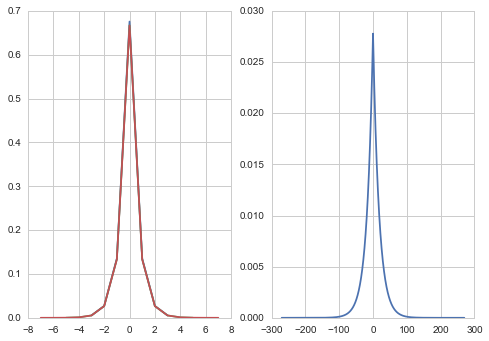

In [403]:
fig, axi = plt.subplots(1,2)

tau = .2

ax = axi[0]
for theta in [3, 5, 7]:
    xs = np.arange(-theta, theta+1)
    Z = laplace_initial_distribution(2*theta+1, {'tau': tau, 'theta': theta})
    ax.plot(xs, np.array(Z)[0])

ax = axi[1]
sc = 45
xs = np.arange(-(sc*6), sc*6, .1)
p = laplace.pdf(xs, loc=0, scale=tau*(sc*2))
ax.plot(xs, p)
#ax.set_ylim(0, .02)

plt.show()

# normal problems

In [31]:
probdf = pd.read_csv('/Users/markant/experiments/exp_chase/chase-v3/static/problems_normal.csv', index_col=0)
probdf['mn_diff'] = probdf['mn_B'] - probdf['mn_A']
probdf['variance'] = probdf['var_A'] # matched variance in both options

problems = {}
for i, row in probdf.iterrows():
    problems[row['id']] = np.array([[row['mn_A'], row['var_A']], 
                                    [row['mn_B'], row['var_B']]])

k = ['normal-%s' % i for i in (range(12) + range(30, 42))]
#k = ['normal-%s' % i for i in [1]]
problems = {pid: problems[pid] for pid in k}

In [32]:
m = CHASEModel(drift='ev',
               startdist='laplace',
               problems=problems,
               problemtype='normal')

In [33]:
pid = 'normal-1'
problems[pid]

array([[24, 25],
       [35, 25]])

In [34]:
d = m.drift(problems[pid], {'pref_units': 'sums', 'optiontype': 'normal'})
print d
.5 * (1 + d)

0.183819053118


0.59190952655914497

In [36]:
r = m.drift.evaluate(problems[pid], {'pref_units': 'sums', 'optiontype': 'normal'})
np.sqrt(r['sigma2'])

29.920728600754362

In [334]:
gen_pars = {'N': 100,
            'theta': 2,
            'p_stay': 0.,
            'tau': 0.001}
samplesize, choices, traces, thresholds = simulate_process(problems, gen_pars, trace=True, 
                                                           problemtype='normal', pref_units='diffs')

In [335]:
thresh = thresholds[pid]

L = np.where(choices[pid]==0)[0]
H = np.where(choices[pid]==1)[0]
np.mean(choices[pid])
tr_L = [traces[pid][i] for i in L]
tr_H = [traces[pid][i] for i in H]

fig, ax = plt.subplots()
ax.plot([0,6],[thresh,thresh], color='black')
ax.plot([0,6],[-thresh,-thresh], color='black')
for trace in tr_L:
    ax.plot(trace, color='blue', alpha=.4, linewidth=1)
for trace in tr_H:
    ax.plot(trace, color='red', alpha=.4, linewidth=1)
plt.show()

In [37]:
OUTDIR = 'process_recovery_normal'
N_ITER = 5
N = 100

In [343]:
# fit theta and p_stay [sums]
thetas  = [1, 3, 5, 7]
p_stays = [0, .3, .6]
taus    = [.001]
fixed = {'pref_units': 'sums', 'optiontype': 'normal', 'tau': .001}
fitting = ['theta', 'p_stay']
SIM_ID = sim_id_str(OUTDIR, fixed, {f: None for f in fitting})

In [412]:
# fit theta and tau [sums]
thetas  = [1, 3, 5, 7]
p_stays = [0]
taus    = [.001, .3, .6]
fixed = {'pref_units': 'sums', 'optiontype': 'normal', 'p_stay': 0}
fitting = ['theta', 'tau']
SIM_ID = sim_id_str(OUTDIR, fixed, {f: None for f in fitting})

In [337]:
# fit theta and p_stay [diffs]
thetas  = [1, 3, 5, 7]
p_stays = [0, .3, .6]
taus    = [.001]
fixed = {'pref_units': 'diffs', 'optiontype': 'normal', 'tau': .001}
fitting = ['theta', 'p_stay']
SIM_ID = sim_id_str(OUTDIR, fixed, {f: None for f in fitting})

In [38]:
# fit theta and tau [diffs]
thetas  = [1, 3, 5, 7]
p_stays = [0]
taus    = [.001, .3, .6]
fixed = {'pref_units': 'diffs', 'optiontype': 'normal', 'p_stay': 0}
fitting = ['theta', 'tau']
SIM_ID = sim_id_str(OUTDIR, fixed, {f: None for f in fitting})

In [39]:
print SIM_ID

results = pd.DataFrame(columns=['problem', 'iteration', 'gen_N', 
                                'gen_cp', 'gen_ss_mn',
                                'gen_theta', 'gen_p_stay', 'gen_tau', 'gen_alpha', 'gen_gamma',
                                'bf_cp', 'bf_ss_mn', 'bf_theta', 'bf_p_stay', 'bf_tau',
                                'bf_alpha', 'bf_gamma_mn'])

for theta, p_stay, tau in itertools.product(thetas, p_stays, taus):


    gen_pars = {'N': N,
                'theta': theta,
                'p_stay': p_stay,
                'tau': tau}

    print theta, p_stay, tau

    for iteration in range(N_ITER):

        data, best, pred = sim_and_fit(problems, gen_pars, fitting, problemtype='normal')

        print iteration
        
        for pid in problems:
            ind = results.shape[0]
            results.loc[ind] = np.nan
            row = results.loc[ind]
            row['problem'] = pid
            row['iteration'] = iteration
            for p in gen_pars:
                row['gen_%s' % p] = gen_pars[p]
            row['gen_ss_mn'] = np.median(np.array(data[data.problem==pid].samplesize.values, int))
            row['gen_cp'] = np.array(data[data.problem==pid].choice, int).mean()

            for p in fitting:
                row['bf_%s' % p] = best[p]
            row['bf_cp'] = pred[pred.problem==pid]['cp'].mean()
            row['bf_ss_mn'] = pred[pred.problem==pid]['ss(.5)'].mean()
            #print row
        
        print row[['gen_theta', 'gen_tau']].values
        print row[['bf_theta', 'bf_tau']].values
        #print
        
results.loc[:,'msd_cp'] = np.mean((results['gen_cp'] - results['bf_cp']).values**2)
results.loc[:,'msd_ss'] = np.mean((results['gen_ss_mn'] - (results['bf_ss_mn']))**2)

process_recovery_normal(tau,theta|optiontype=normal,p_stay=0,pref_units=diffs)
1 0 0.001


TypeError: simulate_process() got an unexpected keyword argument 'pref_units'

In [414]:
arr = []
for theta, p_stay, tau in itertools.product(thetas, p_stays, taus):

    r = results[(results.gen_theta==theta) & (results.gen_p_stay==p_stay) & (results.gen_tau==tau)]
        
    for i, grp in r.groupby('iteration'):
        
        arr.append(pd.concat((
                      grp[['iteration', 'gen_cp', 'gen_ss_mn', 'gen_theta', 'gen_p_stay', 'gen_tau']].mean(),
                      grp[['bf_cp', 'bf_ss_mn', 'bf_theta', 'bf_p_stay', 'bf_tau']].mean(),
                      grp[['msd_cp', 'msd_ss']].mean())))
    
cols = ['iteration', 'gen_cp', 'gen_ss_mn', 'gen_theta', 'gen_p_stay', 'gen_tau',
        'bf_cp_mn', 'bf_ss_mn_mn', 'bf_theta_mn', 'bf_p_stay_mn', 'bf_tau_mn',
        'msd_cp_mn', 'msd_ss_mn']
comb = pd.concat([pd.DataFrame([a.values], columns=cols) for a in arr])
comb.to_csv('%s/%s_recovery_results.csv' % (OUTDIR, SIM_ID))

In [415]:
comb.head()

,iteration,gen_cp,gen_ss_mn,gen_theta,gen_p_stay,gen_tau,bf_cp_mn,bf_ss_mn_mn,bf_theta_mn,bf_p_stay_mn,bf_tau_mn,msd_cp_mn,msd_ss_mn
0,0.0,0.591250,2.020833,1.0,0.0,0.001,0.589542,2.0,2.0,NaN,0.711586,0.002989,69.848264
0,1.0,0.585833,1.833333,1.0,0.0,0.001,0.589542,2.0,2.0,NaN,0.712144,0.002989,69.848264
0,2.0,0.590833,1.937500,1.0,0.0,0.001,0.589833,2.0,2.0,NaN,0.671863,0.002989,69.848264
0,3.0,0.599167,2.062500,1.0,0.0,0.001,0.589542,2.0,2.0,NaN,0.714550,0.002989,69.848264
0,4.0,0.595417,2.000000,1.0,0.0,0.001,0.589667,2.0,2.0,NaN,0.696421,0.002989,69.848264


In [416]:
arr = []
for theta, p_stay, tau in itertools.product(thetas, p_stays, taus):
    r = comb[(np.isclose(comb.gen_theta,theta)) & 
             (np.isclose(comb.gen_p_stay,p_stay)) & 
             (np.isclose(comb.gen_tau,tau))]
    arr.append(np.concatenate((r[['gen_theta', 'gen_p_stay', 'gen_tau']].mean().values,
                          r[['gen_cp', 'gen_ss_mn', 'bf_cp_mn', 'bf_ss_mn_mn', 'bf_theta_mn', 
                             'bf_p_stay_mn', 'bf_tau_mn','msd_cp_mn', 'msd_ss_mn']].mean().values,
                          r[['gen_cp', 'gen_ss_mn', 'bf_cp_mn', 'bf_ss_mn_mn', 'bf_theta_mn', 
                             'bf_p_stay_mn', 'bf_tau_mn','msd_cp_mn', 'msd_ss_mn']].std().values)))


aggdf = pd.DataFrame(arr, columns=['gen_theta', 'gen_p_stay', 'gen_tau',
                                   'gen_cp', 'gen_ss_mn', 'bf_cp_mn', 'bf_ss_mn_mn', 'bf_theta_mn',
                                   'bf_p_stay_mn', 'bf_tau_mn','msd_cp_mn', 'msd_ss_mn',
                                   'gen_cp_sd', 'gen_ss_sd', 'bf_cp_sd', 'bf_ss_sd', 'bf_theta_sd',
                                   'bf_p_stay_sd', 'bf_tau_sd','msd_cp_sd', 'msd_ss_sd'])

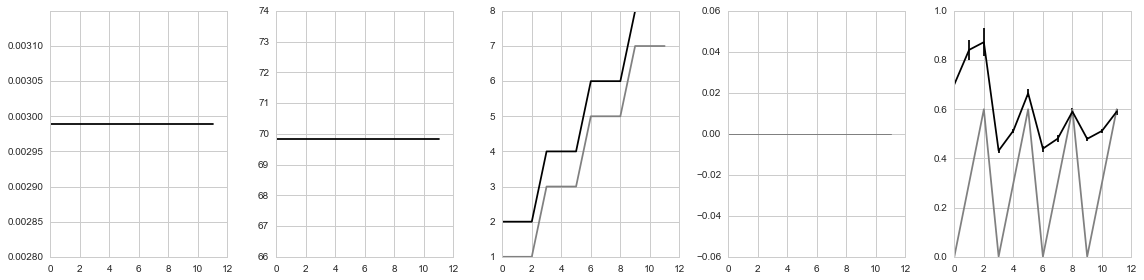

In [417]:
c = ['gray', 'black']

fig, ax = plt.subplots(1, 5, figsize=(16,4))
axi = ax[0]
axi.errorbar(range(aggdf.shape[0]), aggdf['msd_cp_mn'], yerr=aggdf['msd_cp_sd'], color=c[1])

axi = ax[1]
axi.errorbar(range(aggdf.shape[0]), aggdf['msd_ss_mn'], yerr=aggdf['msd_ss_sd'], color=c[1])

axi = ax[2]
axi.plot(range(aggdf.shape[0]), aggdf['gen_theta'], color=c[0])
axi.errorbar(range(aggdf.shape[0]), aggdf['bf_theta_mn'], yerr=aggdf['bf_theta_sd'], color=c[1])

axi = ax[3]
axi.plot(range(aggdf.shape[0]), aggdf['gen_p_stay'], color=c[0], linewidth=1)
axi.errorbar(range(aggdf.shape[0]), aggdf['bf_p_stay_mn'], yerr=aggdf['bf_p_stay_sd'], color=c[1])

axi = ax[4]
axi.plot(aggdf['gen_tau'], color=c[0])
axi.errorbar(range(aggdf.shape[0]), aggdf['bf_tau_mn'], yerr=aggdf['bf_tau_sd'], color=c[1])

plt.tight_layout()
plt.show()

# Glockner problems

In [2]:
def problem_array(row):
    return np.array([[row[['g1o1', 'g1p1']].values, row[['g1o2', 'g1p2']].values],
                     [row[['g2o1', 'g2p1']].values, row[['g2o2', 'g2p2']].values]])


data = pd.read_csv('paper/data/glockner2016/Glockner2016_EB_all.csv', index_col=0)
data = data[(data.description==0) & (data.exp==3)]
probdf = data[['g1o1', 'g1p1', 'g1o2', 'g1p2', 'g2o1', 'g2p1', 'g2o2', 'g2p2']].drop_duplicates().reset_index()

problems = {}
for i, row in probdf.iterrows():
    p = problem_array(row)
    evA = expected_value(p[0])
    evB = expected_value(p[1])
    if evA > evB:
        problems[i] = np.array([p[1], p[0]])
    else:
        problems[i] = p

In [7]:
gen_pars = {'N': 100,
            'theta': 1,
            'p_stay': 0.,
            'tau': 0.001,
            'drift': 'ev',
            'pref_units': 'diffs'}
result = simulate_process(problems, gen_pars, trace=True, problemtype='multinomial')
samplesize = result['samplesize'] 
choices = result['choices']
traces = result['traces']
thresholds = result['thresholds']

process_model.py:488: RuntimeWarning: invalid value encountered in divide
  opt[:,1] = opt[:,1]/opt[:,1].sum()


In [12]:
problems[31]

array([[[  8.  ,   0.9 ],
        [ 29.4 ,   0.1 ]],

       [[ 12.3 ,   0.57],
        [  7.3 ,   0.43]]])

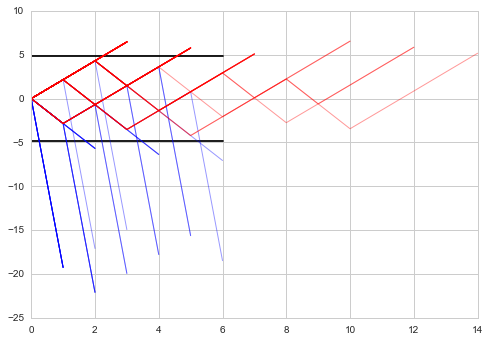

In [11]:
pid = 31
thresh = thresholds[pid]

L = np.where(choices[pid]==0)[0]
H = np.where(choices[pid]==1)[0]
np.mean(choices[pid])
tr_L = [traces[pid][i] for i in L]
tr_H = [traces[pid][i] for i in H]

fig, ax = plt.subplots()
ax.plot([0,6],[thresh,thresh], color='black')
ax.plot([0,6],[-thresh,-thresh], color='black')
for trace in tr_L:
    ax.plot(trace, color='blue', alpha=.4, linewidth=1)
for trace in tr_H:
    ax.plot(trace, color='red', alpha=.4, linewidth=1)
plt.show()

## generate all the data

In [13]:
name = 'process_recovery_glockner'

In [29]:
N = 500
thetas = [1, 2, 3, 4, 5]
p_stays = [0]
taus = [0.001]

for theta, p_stay, tau in itertools.product(thetas, p_stays, taus):
    
    print theta, p_stay, tau
    
    gen_pars = {'N': N,
                'drift': 'ev',
                'pref_units': 'diffs',
                'theta': theta,
                'p_stay': p_stay,
                'tau': tau}
    
    simulate_data(name, problems, gen_pars)

1 0 0.001
2 0 0.001
3 0 0.001
4 0 0.001
5 0 0.001


## fit cpt - objective probabilities

In [30]:
OUTDIR = 'process_recovery_glockner_cpt'
N_ITER = 5
N_FIT_ITER = 1
N = 500

In [31]:
thetas  = [1, 2, 3, 4, 5]
p_stays = [0]
taus    = [.001]

fixed = {}
fitting = ['s', 'prelec_gamma']
SIM_ID = sim_id_str(OUTDIR, fixed, {f: None for f in fitting})

In [32]:
print SIM_ID

results = pd.DataFrame(columns=['problem', 'iteration', 'gen_N', 
                                'gen_cp', 'gen_ss_mn',
                                'gen_theta', 'gen_p_stay', 'gen_tau', 'gen_prelec_gamma',
                                'bf_cp', 'bf_ss_mn', 'bf_s', 'bf_prelec_gamma'])

for theta, p_stay, tau in itertools.product(thetas, p_stays, taus):

    gen_pars = {'N': N,
                'drift': 'ev',
                'pref_units': 'diffs',
                'theta': theta,
                'p_stay': p_stay,
                'tau': tau}


    print theta, p_stay, tau
    
    data, best, pred = fit_simulated_data_cpt(name, problems, gen_pars, fitting, fixed,
                                              iterations=N_FIT_ITER)

    ind = results.shape[0]
    results.loc[ind] = np.nan
    row = results.loc[ind]
    row['gen_theta'] = theta
    row['gen_p_stay'] = p_stay
    row['gen_tau'] = tau
    for p in fitting:
        row['bf_%s' % p] = best[p].values[0]
        
results.to_csv('%s/%s_recovery_results.csv' % (OUTDIR, SIM_ID))

process_recovery_glockner_cpt(prelec_gamma,s|)
1 0 0.001
process_recovery_glockner_cpt(prelec_gamma,s|)
   iteration success  k      N       msd  prelec_gamma         s
0          0    True  2  30000  0.013569      1.072536  0.555436
2 0 0.001
process_recovery_glockner_cpt(prelec_gamma,s|)
   iteration success  k      N       msd  prelec_gamma         s
0          0    True  2  30000  0.005926      1.024261  0.844086
3 0 0.001
process_recovery_glockner_cpt(prelec_gamma,s|)
   iteration success  k      N       msd  prelec_gamma        s
0          0    True  2  30000  0.005174      1.003658  1.75031
4 0 0.001
process_recovery_glockner_cpt(prelec_gamma,s|)
   iteration success  k      N       msd  prelec_gamma         s
0          0    True  2  30000  0.004826      1.000315  2.429749
5 0 0.001
process_recovery_glockner_cpt(prelec_gamma,s|)
   iteration success  k      N       msd  prelec_gamma         s
0          0    True  2  30000  0.005164      0.992479  2.859226


## fit cpt - subjective frequencies

## fit chase

In [33]:
name = 'process_recovery_glockner'
OUTDIR = 'process_recovery_glockner_chase'
N_ITER = 5
N_FIT_ITER = 1
N = 500

In [10]:
# fit theta and p_stay [diffs]
thetas  = [1, 3, 5]
p_stays = [0]
taus    = [.001]
fixed = {'pref_units': 'diffs', 'optiontype': 'multinomial', 'tau': .001, 
         'drift': 'ev', 'minsamplesize': 2, 'amp': True}
fitting = ['theta', 'p_stay']
SIM_ID = sim_id_str(OUTDIR, fixed, {f: None for f in fitting})

In [23]:
# fit theta and tau [diffs]
fit_drift = 'ev'
thetas  = [1, 3, 5]
p_stays = [0]
taus    = [.001, .3, .6]
fixed = {'pref_units': 'diffs', 'optiontype': 'multinomial', 'p_stay': 0}
fitting = ['theta', 'tau']
SIM_ID = sim_id_str(OUTDIR, fixed, {f: None for f in fitting})

In [34]:
# fit theta and p_stay and gamma
thetas  = [1, 2, 3, 4, 5]
p_stays = [0]
taus    = [.001]
fixed = {'pref_units': 'diffs', 'optiontype': 'multinomial', 
         'drift': 'cpt'}
fitting = ['theta', 'sep', 'k', 'prelec_gamma']
SIM_ID = sim_id_str(OUTDIR, fixed, {f: None for f in fitting})

In [32]:
theta = 1
p_stay = 0
tau = .001
gen_pars = {'N': N,
            'drift': 'ev',
            'pref_units': 'diffs',
            'theta': theta,
            'p_stay': p_stay,
            'tau': tau}

data_pth = simulate_data_pth(name, gen_pars)
data = pd.read_csv(data_pth, index_col=0)

fitting = {p: PARS[p] for p in fitting}
SIM_ID = sim_id_str(name, fixed, {f: None for f in fitting})

# initialize the model
m = CHASEModel(drift=fixed['drift'],
               startdist='laplace',
               problems=problems,
               problemtype='multinomial')

pars = deepcopy(fixed)
#pars['p_stay'] = 0.9
pars['tau'] = .001

arr = []
for theta in [1, 2]:
    for sc in [1]:
        for pg in np.arange(.9, 1.15, .025):
            pars['theta'] = theta
            pars['sc'] = sc
            pars['prelec_gamma'] = pg

            nllh = m.nloglik(problems, data, pars)
            print [theta, sc, pg, nllh]
            arr.append([theta, sc, pg, nllh])

[1, 1, 0.90000000000000002, 173372.40686137389]
[1, 1, 0.92500000000000004, 173126.55088616873]
[1, 1, 0.95000000000000007, 172914.45920364474]
[1, 1, 0.97500000000000009, 172735.89469022665]
[1, 1, 1.0, 172587.48382412817]
[1, 1, 1.0250000000000001, 172468.38944075644]
[1, 1, 1.0500000000000003, 172379.16077989744]
[1, 1, 1.0750000000000002, 172317.93736219392]
[1, 1, 1.1000000000000001, 172283.94544448037]
[1, 1, 1.1250000000000002, 172277.62863523065]
[2, 1, 0.90000000000000002, 251077.91278823934]
[2, 1, 0.92500000000000004, 251036.68821431507]
[2, 1, 0.95000000000000007, 251032.43777975216]
[2, 1, 0.97500000000000009, 251063.28651713007]
[2, 1, 1.0, 251127.36192280723]
[2, 1, 1.0250000000000001, 251222.80261231784]
[2, 1, 1.0500000000000003, 251347.76705089823]
[2, 1, 1.0750000000000002, 251500.44191365343]
[2, 1, 1.1000000000000001, 251679.04978046511]
[2, 1, 1.1250000000000002, 251881.85600166634]


In [35]:
print SIM_ID

results = pd.DataFrame(columns=['problem', 'iteration', 'gen_N', 
                                'gen_cp', 'gen_ss_mn',
                                'gen_theta', 'gen_p_stay', 'gen_tau', 'gen_prelec_gamma',
                                'bf_cp', 'bf_ss_mn', 'bf_theta', 'bf_p_stay', 'bf_tau', 'bf_prelec_gamma'])

for theta, p_stay, tau in itertools.product(thetas, p_stays, taus):


    gen_pars = {'N': N,
                'drift': 'ev',
                'pref_units': 'diffs',
                'theta': theta,
                'p_stay': p_stay,
                'tau': tau}


    
    print theta, p_stay, tau
        
    data, best, pred = fit_simulated_data(name, problems, gen_pars, fitting, fixed,
                                          problemtype='multinomial', iterations=N_FIT_ITER)
        
    ind = results.shape[0]
    results.loc[ind] = np.nan
    row = results.loc[ind]
    row['gen_theta'] = theta
    row['gen_p_stay'] = p_stay
    row['gen_tau'] = tau
    for p in fitting:
        row['bf_%s' % p] = best[p]
        
results.to_csv('%s_recovery_results.csv' % (SIM_ID))

process_recovery_glockner_chase(k,prelec_gamma,sep,theta|drift=cpt,optiontype=multinomial,pref_units=diffs)
1 0 0.001
process_recovery_glockner(k,prelec_gamma,sep,theta|drift=cpt,optiontype=multinomial,pref_units=diffs)(k,prelec_gamma,sep,theta|drift=cpt,optiontype=multinomial,pref_units=diffs)
0/5
['theta']: [ 1.]
iteration              0
success             True
nllh             62633.4
k               0.832622
N                  30000
bic               125308
theta                  1
k               0.832622
prelec_gamma     1.17781
sep              4.80034
Name: 0, dtype: object
process_recovery_glockner(k,prelec_gamma,sep,theta|drift=cpt,optiontype=multinomial,pref_units=diffs)(k,prelec_gamma,sep,theta|drift=cpt,optiontype=multinomial,pref_units=diffs)
1/5
['theta']: [ 2.]
iteration              0
success             True
nllh               68861
k                1.27311
N                  30000
bic               137763
theta                  2
k                1.27311
prelec_gamm

In [50]:
cp = [np.mean(data[data.problem==i].choice.values) for i in problems]

In [51]:
bf_cp = [pred[pred.problem==i].cp.mean() for i in problems]

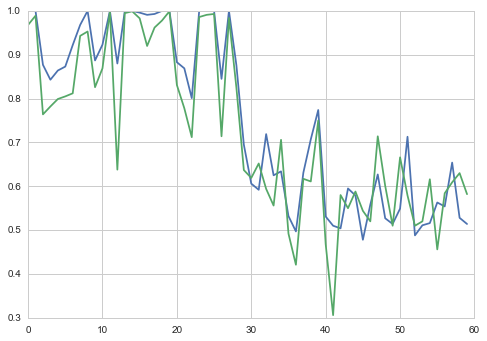

In [52]:
plt.plot(cp)
plt.plot(bf_cp)

In [78]:
pid = 41
problems[pid]

array([[[  2.9 ,   0.06],
        [ 10.6 ,   0.94]],

       [[ 27.5 ,   0.35],
        [  1.2 ,   0.65]]])

In [79]:
print expected_value(problems[pid][0])
print expected_value(problems[pid][1])

10.138
10.405


In [80]:
r = m.drift(problems[pid], pars)

[ 7.505 -0.195]
[ 0.06  0.94]
7.505
-0.195
[ 17.362  -8.938]
[ 0.35  0.65]
17.362
-8.938
0.343057393186
0.448029343058
0.208913263756
1.0


NameError: global name 'dummy' is not defined

In [48]:
r

{'V': array([  8.75,  12.15]),
 'd_down': 0.5,
 'd_up': 0.78683848296954562,
 'evar': array([ 21.6225,   0.5625]),
 'sigma2': 11.092500000000001,
 'values': array([[  4.1,  13.4],
        [ 12.9,  11.4]]),
 'weights': array([[ 0.5,  0.5],
        [ 0.5,  0.5]])}

In [16]:
print (1 - r['d_down'])/2
print (1 + r['d_up'])/2

0.216939770421
0.813002898043


In [17]:
(r['V'][1] - r['V'][0])/np.sqrt(r['sigma2'])

0.53548561605374501

In [18]:
r['V'][1] - r['V'][0]

4.9776836768736334

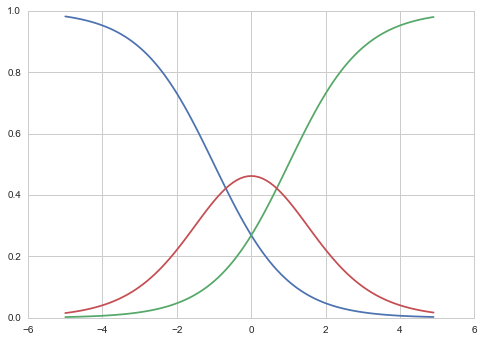

In [109]:
xs = np.arange(-5,5,.1)
k = 1
n = 1
p_down = 1/(1+np.exp(k*(xs+n)))
p_up = 1/(1+np.exp(k*(-xs+n)))
plt.plot(xs, p_down)
plt.plot(xs, p_up)
plt.plot(xs, 1 - (p_down + p_up))

In [19]:
pars = deepcopy(fixed)
for p in fitting:
    pars[p] = best[p]

NameError: name 'best' is not defined

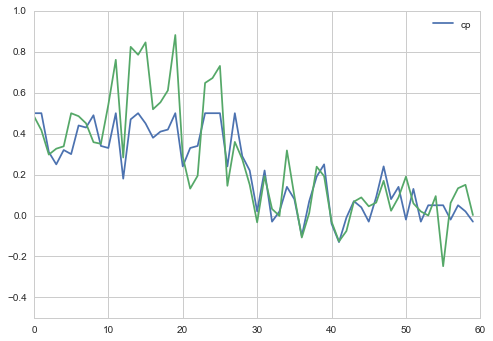

In [92]:
arr0 = []
arr = []
for i in problems:
    r = m.drift(problems[i], pars)
    arr.append(r['d_up']-r['d_down'])
    #arr0.append((r['V'][1] - r['V'][0])/np.sqrt(r['sigma2']))


fig, ax = plt.subplots()
ax.plot(np.array(cp)-.5, label='cp')
ax.plot(arr)
#ax.plot(arr0)
ax.set_ylim(-.5,1)
ax.legend()
plt.show()

TypeError: float() argument must be a string or a number

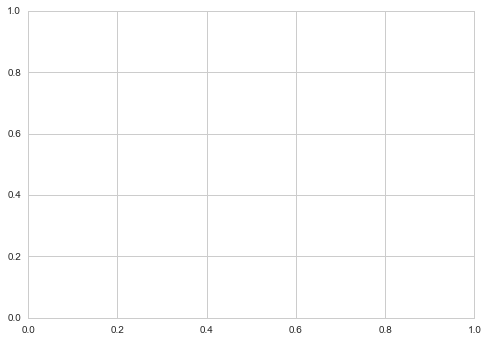

In [148]:
pars['sc'] = 1
plt.plot([m.drift(problems[i], pars) for i in problems])

In [30]:
# initialize the model
m = CHASEModel(drift=fixed['drift'],
               startdist='laplace',
               problems=problems,
               problemtype='multinomial')



TypeError: super(type, obj): obj must be an instance or subtype of type

In [47]:
pr = simulate_process({pid: problems[pid]}, {'theta': 1, 'drift': 'ev', 'pref_units': 'diffs', 'N': 100}, 
                 trace=True)

36 6.32810030736


In [48]:
tr = pr['traces'][pid]

In [49]:
np.mean(pr['choices'][pid])

0.42999999999999999

(array([ 27.,   0.,  44.,   0.,   0.,  25.,   0.,   0.,   0.,   4.]),
 array([ -6.737 ,  -4.1165,  -1.496 ,   1.1245,   3.745 ,   6.3655,
          8.986 ,  11.6065,  14.227 ,  16.8475,  19.468 ]),
 <a list of 10 Patch objects>)

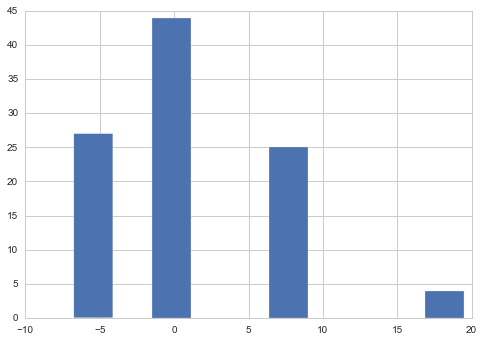

In [51]:
plt.hist([trace[1] for trace in tr])

In [63]:
r = m.drift.evaluate(problems[pid], pars)
evar = r['evar']
print r

[ 0.53  0.47]
[ 17.1   2.7]
10.363
[ 0.07  0.93]
[ 29.8   8.9]
10.332
[-6.737  7.663]
[ 19.468  -1.432]
[-6.737]
[ 0.265]
[-1.432]
[ 0.465]
[ 7.663]
[ 0.235]
[ 19.468]
[ 0.035]
12.981139945
27.064674555


NameError: global name 'dummy' is not defined

In [42]:
problems[41][0][:,0] - 10.405

array([-7.505,  0.195])

In [43]:
problems[41]

array([[[  2.9 ,   0.06],
        [ 10.6 ,   0.94]],

       [[ 27.5 ,   0.35],
        [  1.2 ,   0.65]]])

In [22]:
delta = 10.405 - 10.138
print delta/evar[1]
print delta/evar[0]

print .5 * (delta/np.sqrt(evar[1])) + .5 * (delta/np.sqrt(evar[0]))


print delta/np.sqrt((.5 * evar[1] + .5 * evar[0]))

0.00169675197506
0.079845548207
0.0836470115457
0.0297861028449


In [101]:
from scipy.stats.mstats import mquantiles

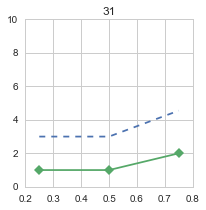

In [180]:
for i in [31]:
    fig, ax = plt.subplots(figsize=(3,3), sharex=True)
    ax.plot([.25, .5, .75], mquantiles(data[data.problem==i].samplesize.values), '--')
    ax.plot([.25, .5, .75], pred[pred.problem==i][['ss(.25)', 'ss(.5)', 'ss(.75)']].mean().values, '-D')
    ax.set_title(i)
    ax.set_ylim(0, 10)
    plt.show()

In [22]:
arr = []
for theta, p_stay, tau in itertools.product(thetas, p_stays, taus):
    print theta, p_stay, tau
    r = results[(results.gen_theta==theta) & (results.gen_p_stay==p_stay) & (results.gen_tau==tau)]
        
    for i, grp in r.groupby('iteration'):
        
        arr.append(pd.concat((
                      grp[['iteration', 'gen_cp', 'gen_ss_mn', 'gen_theta', 'gen_p_stay', 'gen_tau']].mean(),
                      grp[['bf_cp', 'bf_ss_mn', 'bf_theta', 'bf_p_stay', 'bf_tau', 'bf_prelec_gamma']].mean(),
                      grp[['msd_cp', 'msd_ss']].mean())))
    
cols = ['iteration', 'gen_cp', 'gen_ss_mn', 'gen_theta', 'gen_p_stay', 'gen_tau',
        'bf_cp_mn', 'bf_ss_mn_mn', 'bf_theta_mn', 'bf_p_stay_mn', 'bf_tau_mn', 'bf_prelec_gamma_mn',
        'msd_cp_mn', 'msd_ss_mn']
comb = pd.concat([pd.DataFrame([a.values], columns=cols) for a in arr])
comb.to_csv('%s/%s_recovery_results.csv' % (OUTDIR, SIM_ID))

1 0 0.001
1 0.3 0.001
1 0.6 0.001
3 0 0.001
3 0.3 0.001
3 0.6 0.001
5 0 0.001
5 0.3 0.001
5 0.6 0.001


ValueError: No objects to concatenate

In [26]:
arr = []
for theta, p_stay, tau in itertools.product(thetas, p_stays, taus):
    r = comb[(np.isclose(comb.gen_theta,theta)) & 
             (np.isclose(comb.gen_p_stay,p_stay)) & 
             (np.isclose(comb.gen_tau,tau))]
    arr.append(np.concatenate((r[['gen_theta', 'gen_p_stay', 'gen_tau']].mean().values,
                          r[['gen_cp', 'gen_ss_mn', 'bf_cp_mn', 'bf_ss_mn_mn', 'bf_theta_mn', 
                             'bf_p_stay_mn', 'bf_tau_mn', 'bf_prelec_gamma_mn', 'msd_cp_mn', 'msd_ss_mn']].mean().values,
                          r[['gen_cp', 'gen_ss_mn', 'bf_cp_mn', 'bf_ss_mn_mn', 'bf_theta_mn', 
                             'bf_p_stay_mn', 'bf_tau_mn','bf_prelec_gamma_mn','msd_cp_mn', 'msd_ss_mn']].std().values)))


aggdf = pd.DataFrame(arr, columns=['gen_theta', 'gen_p_stay', 'gen_tau',
                                   'gen_cp', 'gen_ss_mn', 'bf_cp_mn', 'bf_ss_mn_mn', 'bf_theta_mn',
                                   'bf_p_stay_mn', 'bf_tau_mn','bf_prelec_gamma_mn','msd_cp_mn', 'msd_ss_mn',
                                   'gen_cp_sd', 'gen_ss_sd', 'bf_cp_sd', 'bf_ss_sd', 'bf_theta_sd',
                                   'bf_p_stay_sd', 'bf_tau_sd','bf_prelec_gamma_sd','msd_cp_sd', 'msd_ss_sd'])

In [27]:
aggdf

,gen_theta,gen_p_stay,gen_tau,gen_cp,gen_ss_mn,bf_cp_mn,bf_ss_mn_mn,bf_theta_mn,bf_p_stay_mn,bf_tau_mn,msd_cp_mn,msd_ss_mn,gen_cp_sd,gen_ss_sd,bf_cp_sd,bf_ss_sd,bf_theta_sd,bf_p_stay_sd,bf_tau_sd,msd_cp_sd,msd_ss_sd
0,1.0,0.0,0.001,0.577000,1.981667,0.567100,2.000000,2.0,NaN,0.706761,0.022782,21.681111,0.027116,0.049089,0.000259,0.000000,0.0,NaN,0.038273,0.0,0.0
1,1.0,0.0,0.300,0.544667,1.940000,0.566767,2.000000,2.0,NaN,0.765618,0.022782,21.681111,0.015829,0.116428,0.000350,0.000000,0.0,NaN,0.054302,0.0,0.0
2,1.0,0.0,0.600,0.534333,1.863333,0.566407,2.000000,2.0,NaN,0.822154,0.022782,21.681111,0.011820,0.094575,0.000371,0.000000,0.0,NaN,0.069618,0.0,0.0
3,3.0,0.0,0.001,0.630667,9.880000,0.632280,10.500000,4.0,NaN,0.405595,0.022782,21.681111,0.028348,0.390050,0.000441,0.000000,0.0,NaN,0.011279,0.0,0.0
4,3.0,0.0,0.300,0.630000,9.600000,0.629337,9.920000,4.0,NaN,0.478916,0.022782,21.681111,0.023154,0.543171,0.000490,0.029814,0.0,NaN,0.013292,0.0,0.0
5,3.0,0.0,0.600,0.613000,8.591667,0.623063,9.400000,4.0,NaN,0.638737,0.022782,21.681111,0.022029,0.327077,0.001065,0.223607,0.0,NaN,0.027562,0.0,0.0
6,5.0,0.0,0.001,0.669333,22.630000,0.683830,23.076667,6.0,NaN,0.418700,0.022782,21.681111,0.011462,0.628258,0.000954,0.194579,0.0,NaN,0.021722,0.0,0.0
7,5.0,0.0,0.300,0.682667,22.215000,0.681963,22.756667,6.0,NaN,0.458521,0.022782,21.681111,0.012053,0.754878,0.001074,0.311047,0.0,NaN,0.021450,0.0,0.0
8,5.0,0.0,0.600,0.674000,21.018333,0.676193,21.843333,6.0,NaN,0.563166,0.022782,21.681111,0.009545,0.427460,0.001117,0.266823,0.0,NaN,0.018286,0.0,0.0


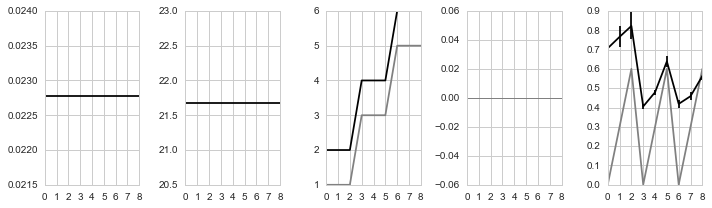

In [28]:
c = ['gray', 'black']

fig, ax = plt.subplots(1, 5, figsize=(10,3))
axi = ax[0]
axi.errorbar(range(aggdf.shape[0]), aggdf['msd_cp_mn'], yerr=aggdf['msd_cp_sd'], color=c[1])

axi = ax[1]
axi.errorbar(range(aggdf.shape[0]), aggdf['msd_ss_mn'], yerr=aggdf['msd_ss_sd'], color=c[1])

axi = ax[2]
axi.plot(range(aggdf.shape[0]), aggdf['gen_theta'], color=c[0])
axi.errorbar(range(aggdf.shape[0]), aggdf['bf_theta_mn'], yerr=aggdf['bf_theta_sd'], color=c[1])

axi = ax[3]
axi.plot(range(aggdf.shape[0]), aggdf['gen_p_stay'], color=c[0], linewidth=1)
axi.errorbar(range(aggdf.shape[0]), aggdf['bf_p_stay_mn'], yerr=aggdf['bf_p_stay_sd'], color=c[1])

axi = ax[4]
axi.plot(aggdf['gen_tau'], color=c[0])
axi.errorbar(range(aggdf.shape[0]), aggdf['bf_tau_mn'], yerr=aggdf['bf_tau_sd'], color=c[1])

plt.tight_layout()
plt.show()

# 6-problems

In [100]:
pid = '6p-2'
L = np.where(choices[pid]==0)[0]
H = np.where(choices[pid]==1)[0]
np.mean(choices[pid])

0.42999999999999999

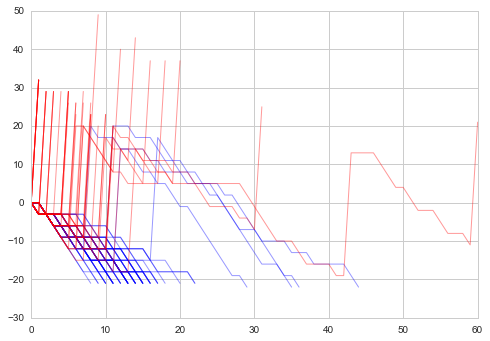

In [101]:
tr_L = [traces[pid][i] for i in L]
tr_H = [traces[pid][i] for i in H]

fig, ax = plt.subplots()
for trace in tr_L:
    ax.plot(trace, color='blue', alpha=.4, linewidth=1)
for trace in tr_H:
    ax.plot(trace, color='red', alpha=.4, linewidth=1)
plt.show()


In [27]:
results = pd.DataFrame(columns=['problem', 'iteration', 'gen_N', 
                                'gen_cp', 'gen_ss_mn',
                                'gen_theta', 'gen_p_stay', 'gen_tau', 'gen_alpha', 'gen_gamma',
                                'bf_cp', 'bf_ss_mn', 'bf_theta', 'bf_p_stay', 'bf_tau',
                                'bf_alpha', 'bf_gamma_mn'])


N_ITER = 1
N = 10000
thetas  = [1, 3, 5, 10]
p_stays = [0.]
taus    = [.001, .4]
fitting = ['theta', 'tau']

#problem_pars = HBWE_PROBLEMS
#problems = HBWE_PROBLEMS


#for i, pset in enumerate(problem_pars):
#    problems = {i: generate_normal_problem(pset)}
problem_pars = problems[1]


for theta in thetas:
    for p_stay in p_stays:
        for tau in taus:
            gen_pars = {'N': N,
                        'theta': theta,
                        'p_stay': p_stay,
                        'tau': tau}

            print theta, p_stay, tau
            
            
            for iteration in range(N_ITER):

                data, best, pred = sim_and_fit(problem_pars, gen_pars, fitting)
                
                for pid in problems:
                    ind = results.shape[0]
                    results.loc[ind] = np.nan
                    row = results.loc[ind]
                    row['problem'] = pid
                    row['iteration'] = iteration
                    for p in gen_pars:
                        row['gen_%s' % p] = gen_pars[p]
                    row['gen_ss_mn'] = np.median(np.array(data[data.problem==pid].samplesize.values, int))
                    row['gen_cp'] = np.array(data[data.problem==pid].choice, int).mean()

                    for p in fitting:
                        row['bf_%s' % p] = best[p]
                    row['bf_cp'] = pred[pred.problem==pid]['cp'].mean()
                    row['bf_ss_mn'] = pred[pred.problem==pid]['ss(.5)'].mean()
                    print row

1 0.0 0.001
[ 0.5077]
recover_process_data(tau,theta|)
chase_fitresults_recover_process_data/recover_process_data(tau,theta|).csv
recover_process_data(tau,theta|)
chase_fitresults_recover_process_data/recover_process_data(tau,theta|).csv
problem               1
iteration             0
gen_N             10000
gen_cp           0.5077
gen_ss_mn             1
gen_theta             1
gen_p_stay            0
gen_tau           0.001
gen_alpha           NaN
gen_gamma           NaN
bf_cp             0.529
bf_ss_mn              1
bf_theta              1
bf_p_stay           NaN
bf_tau         0.511614
bf_alpha            NaN
bf_gamma_mn         NaN
Name: 0, dtype: object
1 0.0 0.4
[ 0.5016]
recover_process_data(tau,theta|)
chase_fitresults_recover_process_data/recover_process_data(tau,theta|).csv
recover_process_data(tau,theta|)
chase_fitresults_recover_process_data/recover_process_data(tau,theta|).csv
problem                1
iteration              0
gen_N              10000
gen_cp            0.

/Users/markant/code/chase/chase/base.py:123: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  p_stop_cond = p_stop_cond.reshape((self.max_T, 1./self.dt, 2)).sum(axis=1)


In [28]:
results.loc[:,'msd_cp'] = np.abs((results['gen_cp'] - results['bf_cp']).values)
results.loc[:,'msd_ss'] = np.abs((results['gen_ss_mn'] - (results['bf_ss_mn'])))

# use first problem to select out parameters (same for all problems)
pid = '6p-0'

arr = []
for i, grp in results[results.problem==pid].groupby(['gen_theta', 'gen_p_stay', 'gen_tau']):
    arr.append(pd.concat((grp[['gen_cp', 'gen_ss_mn', 'gen_theta', 'gen_p_stay', 'gen_tau']].mean(),
                          grp[['bf_cp', 'bf_ss_mn', 'bf_theta', 'bf_p_stay', 'bf_tau']].mean(),
                          grp[['bf_cp', 'bf_ss_mn', 'bf_theta', 'bf_p_stay', 'bf_tau']].std(),
                          grp[['msd_cp', 'msd_ss']].mean(), grp[['msd_cp', 'msd_ss']].std())))

cols = ['gen_cp', 'gen_ss_mn', 'gen_theta', 'gen_p_stay', 'gen_tau',
        'bf_cp_mn', 'bf_ss_mn_mn', 'bf_theta_mn', 'bf_p_stay_mn', 'bf_tau_mn',
        'bf_cp_sd', 'bf_ss_mn_sd', 'bf_theta_sd', 'bf_p_stay_sd', 'bf_tau_sd',
        'msd_cp_mn', 'msd_ss_mn', 'msd_cp_sd', 'msd_ss_sd']
comb = pd.concat([pd.DataFrame([a.values], columns=cols) for a in arr])

ValueError: No objects to concatenate

In [11]:
comb

,gen_cp,gen_ss_mn,gen_theta,gen_p_stay,gen_tau,bf_cp_mn,bf_ss_mn_mn,bf_theta_mn,bf_p_stay_mn,bf_tau_mn,bf_cp_sd,bf_ss_mn_sd,bf_theta_sd,bf_p_stay_sd,bf_tau_sd,msd_cp_mn,msd_ss_mn,msd_cp_sd,msd_ss_sd
0,0.4114,2.0,1.0,0.0,0.001,0.531,4.6,2.2,0.000025,1.999832e-01,0.002236,1.341641,0.447214,0.000027,0.447175,0.1196,2.6,0.013921,1.341641
0,0.5374,2.0,3.0,0.0,0.001,0.530,4.0,2.0,0.000026,9.989072e-07,0.000000,0.000000,0.000000,0.000018,0.000002,0.0154,2.0,0.008532,0.000000
0,0.5416,5.0,5.0,0.0,0.001,0.544,9.0,3.0,0.000005,1.232778e-01,0.000000,0.000000,0.000000,0.000009,0.005390,0.0064,4.0,0.007092,0.000000


In [12]:
# comb.to_csv('process_recovery_problems=normal.csv')
comb.to_csv('process_recovery_problems=6p.csv')

In [902]:
comb = pd.read_csv('process_recovery_problems=normal.csv', index_col=0)

In [966]:
comb = pd.read_csv('process_recovery_problems=6p-0.csv', index_col=0)

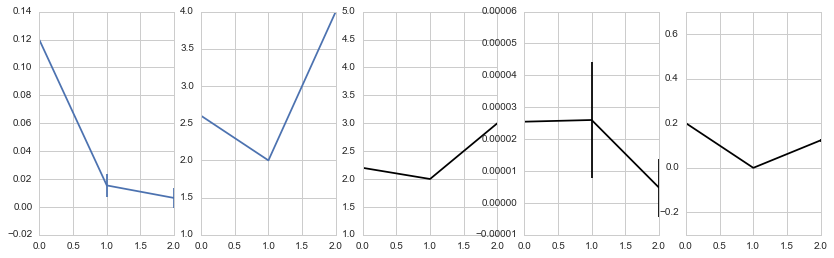

In [13]:
c = ['gray', 'black']

fig, ax = plt.subplots(1, 5, figsize=(14,4))
axi = ax[0]
axi.errorbar(range(comb.shape[0]), comb['msd_cp_mn'], yerr=comb['msd_cp_sd'])

axi = ax[1]
axi.errorbar(range(comb.shape[0]), comb['msd_ss_mn'], yerr=comb['msd_ss_sd'])

axi = ax[2]
axi.plot(comb['gen_theta'], color=c[0])
axi.errorbar(range(comb.shape[0]), comb['bf_theta_mn'], yerr=comb['bf_theta_sd'], color=c[1])

axi = ax[3]
axi.plot(comb['gen_p_stay'], color=c[0], linewidth=1)
axi.errorbar(range(comb.shape[0]), comb['bf_p_stay_mn'], yerr=comb['bf_p_stay_sd'], color=c[1])

axi = ax[4]
axi.plot(comb['gen_tau'], color=c[0])
axi.errorbar(range(comb.shape[0]), comb['bf_tau_mn'], yerr=comb['bf_tau_sd'], color=c[1])



plt.show()

In [594]:
cp_sim = []
cp_pred = []
ss_sim = []
ss_pred = []
bf_par = []

thetas = [1, 3, 5, 7, 9]

for theta in thetas:
    
    problem_pars = [[[1, .1], [10, .1]]]
    gen_pars = {'N': N,
               'theta': theta,
               'p_stay': 0.3}
    fitting = ['theta', 'p_stay']
    data, best, pred = sim_and_fit(problem_pars, gen_pars, fitting)
    
    bf_par.append(best[fitting].values)
    
    samplesize = data.samplesize.values-1
    choices = data.choice.values
    
    cp_sim.append(choices.mean())
    cp_pred.append(pred[0]['p_resp'][1])
    
    ss_sim.append(samplesize.mean())
    ss_pred.append(pred[0]['exp_samplesize'][0,1]*cp_pred[-1] + pred[0]['exp_samplesize'][0,0]*(1-cp_pred[-1]))

1 0.398 5.025
3 0.77 28.637
5 0.995 27.821
7 0.992 59.797
9 1.0 41.324


In [629]:
cp_sim = []
cp_pred = []
ss_sim = []
ss_pred = []
bf_par = []

ss_all = []
ss_pred_all = []

thetas = [1, 3, 5, 7, 9]

for theta in thetas:
    
    problem_pars = [[[1, .01], [3, .1]]]
    gen_pars = {'N': N,
               'theta': theta,
               'p_stay': 0.3}
    fitting = ['theta', 'p_stay']
    data, best, pred = sim_and_fit(problem_pars, gen_pars, fitting)
    
    bf_par.append(best[fitting].values)
    
    samplesize = data.samplesize.values-1
    ss_all.append(samplesize)
    choices = data.choice.values
    
    cp_sim.append(choices.mean())
    cp_pred.append(pred[0]['p_resp'][1])
    
    ss_sim.append(samplesize.mean())
    ss_pred.append(pred[0]['exp_samplesize'][0,1]*cp_pred[-1] + pred[0]['exp_samplesize'][0,0]*(1-cp_pred[-1]))
    ss_pred_all.append(np.array(pred[0]['p_resp_t'][:,1]*cp_pred[-1] + pred[0]['p_resp_t'][:,0]*(1-cp_pred[-1]))[:,0])

1 0.382 4.396
3 0.796 24.024
5 0.962 44.567
7 0.984 69.581
9 0.996 96.442


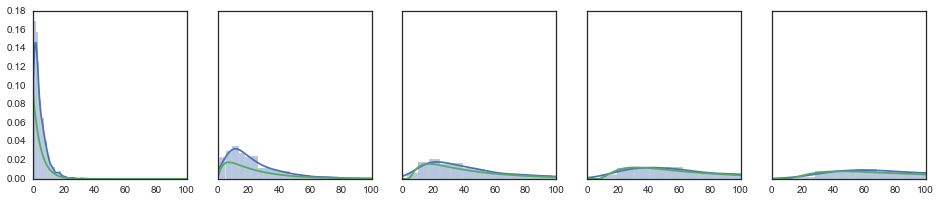

In [631]:
# compare sample size distributions
fig, ax = plt.subplots(1, len(thetas), figsize=(16,3), sharey=True)
for i in range(len(thetas)):
    sns.distplot(ss_all[i], ax=ax[i])
    ax[i].plot(ss_pred_all[i])

    ax[i].set_xlim(0,100)
plt.show()

In [632]:
cp_sim = []
cp_pred = []
ss_sim = []
ss_pred = []
bf_par = []

ss_all = []
ss_pred_all = []

thetas = [1, 3, 5, 7, 9]

for theta in thetas:
    
    problem_pars = [[[1, .1], [10, .1]]]
    gen_pars = {'N': N,
               'theta': theta,
               'p_stay': 0.3,
               'pow_gain': .7}
    fitting = ['theta', 'p_stay', 'pow_gain']
    data, best, pred = sim_and_fit(problem_pars, gen_pars, fitting)
    
    bf_par.append(best[fitting].values)
    
    samplesize = data.samplesize.values-1
    ss_all.append(samplesize)
    choices = data.choice.values
    
    cp_sim.append(choices.mean())
    cp_pred.append(pred[0]['p_resp'][1])
    
    ss_sim.append(samplesize.mean())
    ss_pred.append(pred[0]['exp_samplesize'][0,1]*cp_pred[-1] + pred[0]['exp_samplesize'][0,0]*(1-cp_pred[-1]))
    ss_pred_all.append(np.array(pred[0]['p_resp_t'][:,1]*cp_pred[-1] + pred[0]['p_resp_t'][:,0]*(1-cp_pred[-1]))[:,0])

1 0.493 4.023
3 0.848 23.743
5 0.984 30.082
7 1.0 34.104
9 0.934 158.052


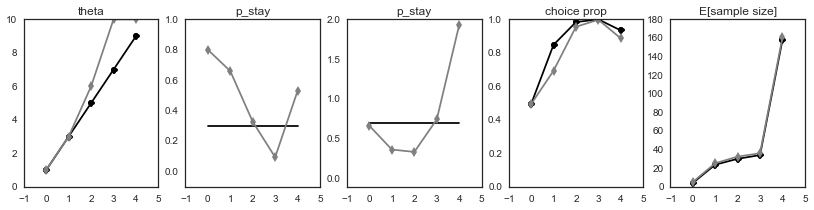

In [635]:
cols = ['black', 'gray']

fig, ax = plt.subplots(1, 5, figsize=(14,3))

ax[0].plot(thetas, '-o', color=cols[0])
ax[0].plot([b[0] for b in bf_par], '-d', color=cols[1])
ax[0].set_ylim(0, 10)
ax[0].set_title('theta')

ax[1].plot([gen_pars['p_stay'] for _ in range(len(thetas))], color=cols[0])
ax[1].plot([b[1] for b in bf_par], '-d', color=cols[1])
ax[1].set_ylim(-.1, 1)
ax[1].set_title('p_stay')

ax[2].plot([gen_pars['pow_gain'] for _ in range(len(thetas))], color=cols[0])
ax[2].plot([b[2] for b in bf_par], '-d', color=cols[1])
ax[2].set_ylim(-.1, 2)
ax[2].set_title('pow_gain')

ax[3].plot(cp_sim, '-o', color=cols[0])
ax[3].plot(cp_pred, '-d', color=cols[1])
ax[3].set_ylim(0, 1)
ax[3].set_title('choice prop')

ax[4].plot(ss_sim, '-o', color=cols[0])
ax[4].plot(ss_pred, '-d', color=cols[1])
ax[4].set_title('E[sample size]')

for axi in ax:
    axi.set_xlim(-1, len(thetas))

plt.show()

# One setting

In [483]:
# construct a problem set with normally distributed outcomes
pars = [[1, 3.], [4, 3.]]
n_x = 30

prob = []
for m, s in pars:
    
    outcomes = norm.rvs(m, s, n_x)
    p = norm.pdf(outcomes)
    p = p/p.sum()

    prob.append(np.transpose((outcomes, p)))
problem = np.array(prob)

problems = {0: problem}

In [484]:
print problems[0][0][:,0].mean()
print problems[0][1][:,0].mean()

0.926569431514
3.87188071878


In [495]:
N = 1000
genpars = {'N': N,
           'theta': 3,
           'p_stay': 0.1}
samplesize, choices = simulate_process(problems, genpars)
print choices[0].mean()

data = []
for i, problem in enumerate(problems):
    arr = np.transpose((np.ones(N, int)*np.nan, np.ones(N, int)*i, np.zeros(N, int), choices[i,:], samplesize[i,:]))
    data.append(arr)
data = pd.DataFrame(np.concatenate(data), columns=['subject', 'problem', 'group', 'choice', 'samplesize'])

3 3.84625155922
0.577


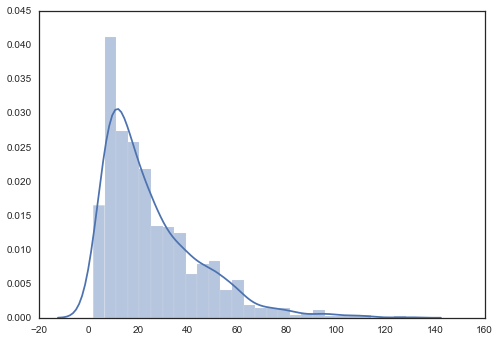

In [496]:
sns.distplot(samplesize[0])
plt.show()

In [ ]:
FIXED = {}
N_ITER = 1
SIM_ID = 'recover_process_data'
OUTDIR = 'chase_fitresults_recover_process_data'

# a list of different parameter combinations that will
# be fit
PARSETS = [['theta', 'p_stay']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    
    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='indifferent')
        
    # fit
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)
    
    #print results.sort('nllh')

In [498]:
# create a table summarizing the best-fitting result for each parameter
# combination
allresults = pd.DataFrame(columns=['sim_id', 'k', 'N', 'nllh', 'bic'])
for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    allresults.loc[allresults.shape[0]] = best_result(SIM_ID, FIXED, 
                                                      fitting, outdir=OUTDIR, nopars=True)
#allresults.to_csv('%s/%s_fitsummary.csv' % (OUTDIR, SIM_ID))
allresults.sort('bic')

,sim_id,k,N,nllh,bic
0,"recover_process_data(p_stay,theta|)",2,1000,4803.13754,9620.09059


In [499]:
# show the fitting results for the model with the lowest BIC
fitting = {p: PARS[p] for p in PARSETS[0]}
best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)

index                                           1
Unnamed: 0                                      1
iteration                                       0
success                                      True
nllh                                     4803.138
k                                               2
N                                            1000
bic                                      9620.091
theta                                           2
p_stay                                  0.8457031
sim_id        recover_process_data(p_stay,theta|)
Name: 0, dtype: object

In [500]:
# for the model with lowest BIC, run the model and get the 
# predicted choice proportions and sample size distribution
m = CHASEModel(drift='cpt', startdist='indifferent')
pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)

In [501]:
print np.round([1-choices[0].mean(), choices[0].mean()],2), np.round(pred[0]['p_resp'],2)
print np.round([samplesize[0][choices[0]==0.].mean(), samplesize[0][choices[0]==1.].mean()],2), pred[0]['exp_samplesize']

[ 0.42  0.58] [ 0.48  0.52]
[ 25.32  25.53] [[ 25.91163851  25.91163851]]


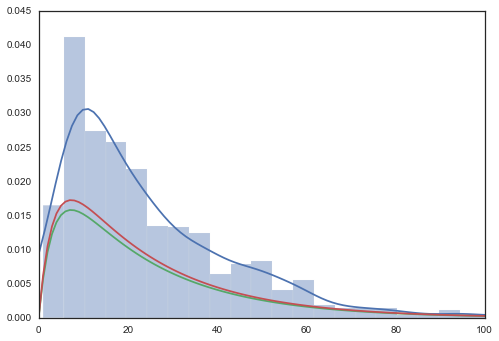

In [502]:
fig, ax = plt.subplots()
sns.distplot(samplesize[0]-1, norm_hist=True, ax=ax)
ax.plot(np.array(pred[0]['p_resp_t'][:,0])[:,0])
ax.plot(np.array(pred[0]['p_resp_t'][:,1])[:,0])
ax.set_xlim(0, 100)
plt.show()

# Binary gambles

In [656]:
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}

In [658]:
problems = {0: problems[0]}

In [660]:
cp_sim = []
cp_pred = []
ss_sim = []
ss_pred = []
bf_par = []

thetas = [1, 3, 5, 7, 9]

n_prob = 1

for theta in thetas:
    
    gen_pars = {'N': N,
               'theta': theta,
               'p_stay': 0.}
    fitting = ['theta', 'p_stay']
    data, best, pred = sim_and_fit([], gen_pars, fitting, problems=problems)
    
    bf_par.append(best[fitting].values)
    
    samplesize = [data[data.problem==pid].samplesize.values-1 for pid in range(n_prob)]
    choices = [data[data.problem==pid].choice.values for pid in range(n_prob)]
    
    cp_sim.append([choices[i].mean() for i in range(n_prob)])
    cp_pred.append([pred[pid]['p_resp'][1] for pid in range(n_prob)])
    
    ss_sim.append([samplesize[pid].mean() for pid in range(n_prob)])
    ss_pred.append([pred[pid]['exp_samplesize'][0,1]*cp_pred[-1][pid] + pred[pid]['exp_samplesize'][0,0]*(1-cp_pred[-1][pid]) \
                    for pid in range(n_prob)])

1 0.444 0.091
3 0.516 2.447
5 0.524 6.243
7 0.548 15.076
9 0.581 22.601


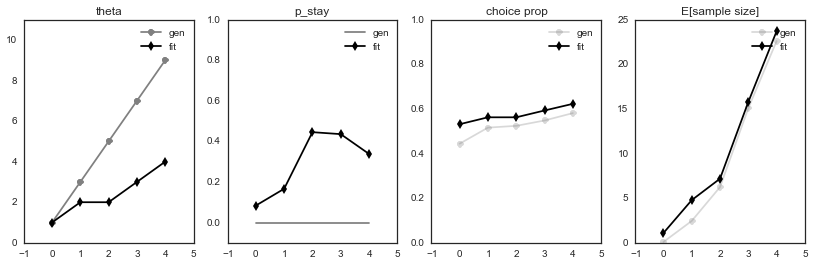

In [663]:
cols = ['gray', 'black']

fig, ax = plt.subplots(1, 4, figsize=(14,4))

ax[0].plot(thetas, '-o', color=cols[0], label='gen')
ax[0].plot([b[0] for b in bf_par], '-d', color=cols[1], label='fit')
ax[0].set_ylim(0, 11)
ax[0].set_title('theta')

ax[1].plot([0 for _ in range(len(thetas))], color=cols[0], label='gen')
ax[1].plot([b[1] for b in bf_par], '-d', color=cols[1], label='fit')
ax[1].set_ylim(-.1, 1)
ax[1].set_title('p_stay')

ax[2].plot(cp_sim, '-o', color=cols[0], alpha=.3, label='gen')
ax[2].plot(cp_pred, '-d', color=cols[1], label='fit')
ax[2].set_ylim(0, 1)
ax[2].set_title('choice prop')

ax[3].plot(ss_sim, '-o', color=cols[0], alpha=.3, label='gen')
ax[3].plot(ss_pred, '-d', color=cols[1], label='fit')
ax[3].set_title('E[sample size]')

for axi in ax:
    axi.set_xlim(-1, len(thetas))
    axi.legend()

plt.show()

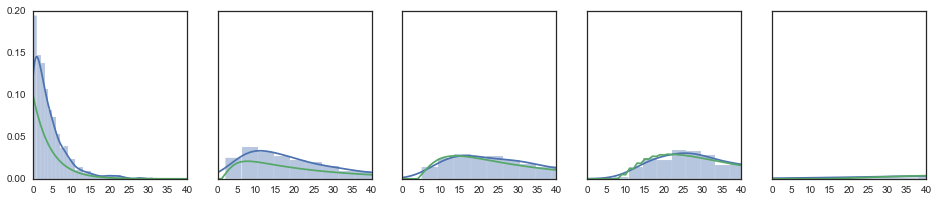

In [665]:
# compare sample size distributions
fig, ax = plt.subplots(1, len(thetas), figsize=(16,3), sharey=True)
for i in range(len(thetas)):
    for pid in range(n_prob):
        sns.distplot(ss_all[i], ax=ax[i])
        ax[i].plot(ss_pred_all[i])

    ax[i].set_xlim(0,40)
plt.show()

In [598]:
N = 1000
genpars = {'N': N,
           'theta': 6,
           'p_stay': 0.1}
samplesize, choices = simulate_process(problems, genpars)
print choices.mean(axis=1)

data = []
for i, problem in enumerate(problems):
    arr = np.transpose((np.ones(N, int)*np.nan, np.ones(N, int)*i, np.zeros(N, int), choices[i,:], samplesize[i,:]))
    data.append(arr)
data = pd.DataFrame(np.concatenate(data), columns=['subject', 'problem', 'group', 'choice', 'samplesize'])

[ 0.538  0.516  0.533  0.541  0.518  0.444]


In [599]:
N_ITER = 1
SIM_ID = 'recover_process_data'
OUTDIR = 'chase_fitresults_recover_process_data'
FIXED = {}
PARSETS = [['theta', 'p_stay']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    
    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='indifferent')
        
    # fit
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)
    
    print results.sort('nllh')

recover_process_data(p_stay,theta|)
0/10
['theta']: [ 1.]
iteration            0
success           True
nllh          35010.43
k                    2
N                 6000
bic           70038.26
theta                1
p_stay       0.9842529
Name: 0, dtype: object
recover_process_data(p_stay,theta|)
1/10
['theta']: [ 2.]
iteration            0
success           True
nllh          35769.38
k                    2
N                 6000
bic           71556.15
theta                2
p_stay       0.9324219
Name: 1, dtype: object
recover_process_data(p_stay,theta|)
2/10
['theta']: [ 3.]
iteration            0
success           True
nllh          36669.42
k                    2
N                 6000
bic           73356.23
theta                3
p_stay       0.8355469
Name: 2, dtype: object
recover_process_data(p_stay,theta|)
3/10
['theta']: [ 4.]
iteration            0
success           True
nllh          38897.35
k                    2
N                 6000
bic            77812.1
theta    

In [600]:
# show the fitting results for the model with the lowest BIC
fitting = {p: PARS[p] for p in PARSETS[0]}
print best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)

m = CHASEModel(drift='cpt', startdist='indifferent')
pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)

index                                           0
Unnamed: 0                                      0
iteration                                       0
success                                      True
nllh                                     35010.43
k                                               2
N                                            6000
bic                                      70038.26
theta                                           1
p_stay                                  0.9842529
sim_id        recover_process_data(p_stay,theta|)
Name: 0, dtype: object


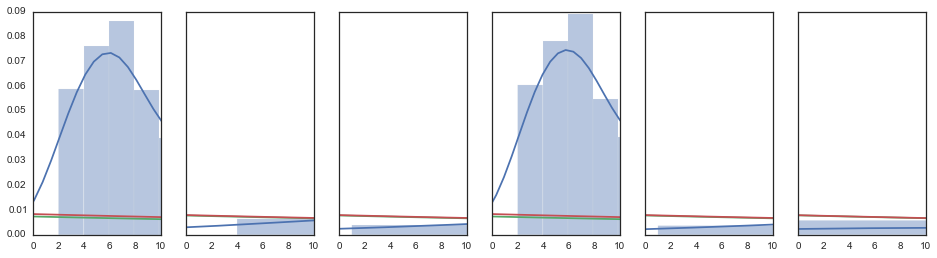

In [601]:
fig, ax = plt.subplots(1, 6, figsize=(16,4), sharey=True)
for pid in problems:
    sns.distplot(samplesize[pid]-1, ax=ax[pid])
    
    ax[pid].plot(np.array(pred[pid]['p_resp_t'][:,0])[:,0])
    ax[pid].plot(np.array(pred[pid]['p_resp_t'][:,1])[:,0])

    ax[pid].set_xlim(0,10)
plt.show()

# Recovery

In [253]:
from cogmod import cpt as cptmodel

def fit_chase(problems, data, fit_pars):
        
    FIXED = {}
    N_ITER = 1
    SIM_ID = 'recover_process_data'
    OUTDIR = 'chase_fitresults_recover_process_data'

    fitting = {p: PARS[p] for p in fit_pars}

    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='laplace',
                   problems=problems)

    # fit
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR, quiet=False)
    best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                               fitting = fitting, 
                               outdir=OUTDIR)

    return best, pred


PARS = {'theta': [1, 10],
        'c': [.01, 2, .5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],}

fitting_cpt = {'s': [0, np.inf, 1.],
               'prelec_gamma': [0, 10, 1.]}

def predicted_samplesize(pred):
    cp = pred['p_resp'][1]
    ss = pred['p_stop_cond'][:,1]*cp + pred['p_stop_cond'][:,0]*(1-cp)
    ss = ss/float(ss.sum())
    return np.array(ss)

def observed_samplesize(data):
    bc = np.bincount(data.samplesize)
    return bc/float(bc.sum())

def predicted_cp(pred):
    cp = pred['p_resp'][1]
    return cp

def observed_cp(data):
    return data.choice.mean()

In [3]:
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}
#problems = {i: arr[i].reshape((2,2,2)) for i in range(1)}
#problems = [arr[i].reshape((2,2,2)) for i in range(len(arr))]

In [69]:
import pickle

In [132]:
with open('/Users/markant/code/chase/chase/paper/glockner_exp3_problems.pkl', 'r') as f:
    glockner_exp3_problems = pickle.load(f)

problems = {}
for p in glockner_exp3_problems:
    if np.sum(glockner_exp3_problems[p][:,:,0].ravel() < 0)==0:
        if np.random.random() < .05:
            problems[p] = glockner_exp3_problems[p]

In [75]:
with open('/Users/markant/code/chase/chase/paper/data/tpt_problems.pkl', 'r') as f:
    problems = pickle.load(f)

## Single problem, normally distributed outcomes

In [462]:
problems = {i: generate_normal_problem([[1, 1.], [2, 1.]], n_x=5) for i in range(1)}

In [463]:
N = 10000  # N has to be low enough for sampling error to have an impact! 

gen_pars = []
for gamma in [1.]:
    for theta in [3, 6, 9]:
        for p_stay in [0., .3]:
        
            gen_pars.append({'N': N,
                             'theta': theta,
                             'p_stay': p_stay,
                             'prelec_gamma': gamma})

In [464]:
cols = ['theta', 'p_stay', 'gamma', 'subject', 'problem', 'problem-subject', 'group', 'choice', 'samplesize']
df = pd.DataFrame(columns=cols)

for gp in gen_pars:

    samplesize, choices, problems_exp = simulate_process(problems, gp, relfreq=True)
    print np.round([choices[pid].mean() for pid in problems], 3)

    data = []
    for pid in problems:
        arr = np.transpose(([gp['theta'] for _ in range(N)], 
                            [gp['p_stay'] for _ in range(N)],
                            [gp['prelec_gamma'] for _ in range(N)],
                            range(N), 
                            [pid for _ in range(N)], 
                            [('%s-%s' % (pid, i)) for i in range(N)],
                            np.zeros(N, int), 
                            np.array(choices[pid], int), np.array(samplesize[pid], int)))
        data.append(arr)
    data = pd.DataFrame(np.concatenate(data, axis=0), columns=cols)
    df = pd.concat((df, data))

df = df.convert_objects(convert_numeric=True)      

#problems_exp_by_subj = {}
#for i in range(N):
#    for pid in problems:
#        problems_exp_by_subj['%s-%s' % (pid, i)] = problems_exp[pid][i]

[ 0.39]
[ 0.392]
[ 0.324]
[ 0.326]
[ 0.274]
[ 0.275]


In [465]:
cpt_fits_obj = {}
cpt_fits_exp = {}
chase_fits = {}
N_FIT_ITER = 1

In [ ]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'p_stay', 'tau'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

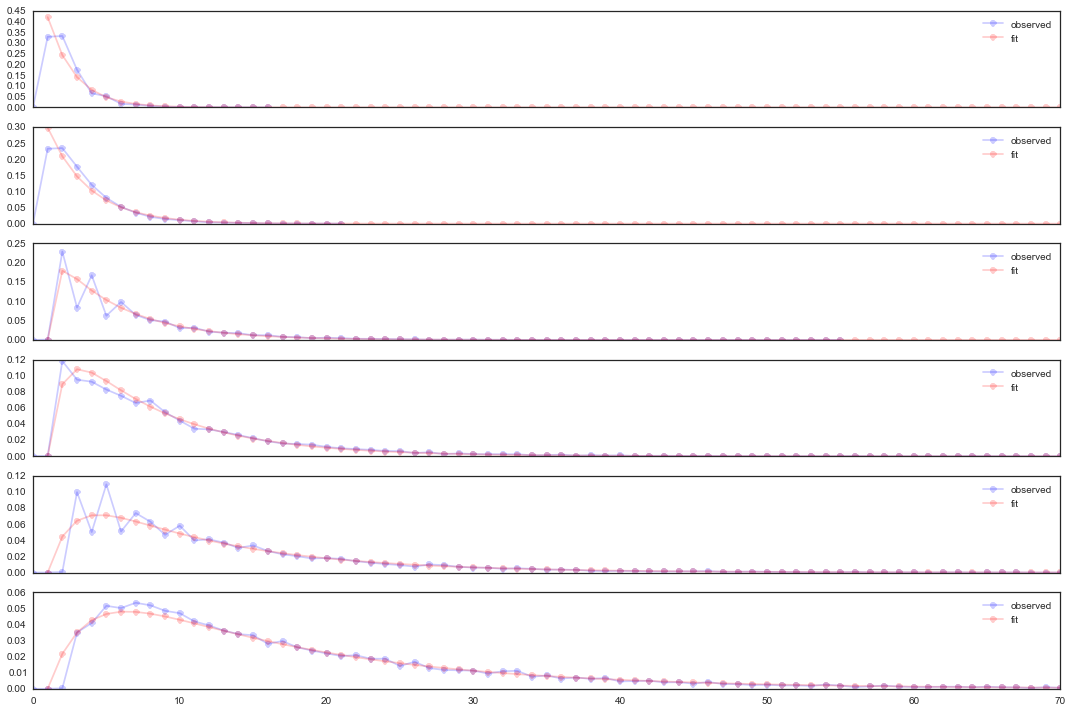

In [472]:
fig, axi = plt.subplots(len(gen_pars), 1, figsize=(15,10), sharex=True)

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    ax = axi[i]
    
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(ss, '-o', color='blue', alpha=.2, label='observed')
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-o', color='red', alpha=.2, label='fit')
        ax.set_xlim(0, 70)
        ax.legend()
plt.tight_layout()
plt.show()

In [474]:
bf_par   = {'theta': [], 'p_stay': [], 'tau': []}
true_par = {'theta': [], 'p_stay': [], 'tau': []}

for gp in gen_pars:
    
    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    for par in ['theta', 'p_stay', 'tau']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 3, figsize=(14,4))

for i, par in enumerate(['theta', 'p_stay', 'tau']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()

## multiple problems, normally distributed outcomes

In [242]:
problems = {i: generate_normal_problem([[1, 1.], [2, 1.]], n_x=3) for i in range(100)}

In [243]:
cpt_fits_obj = {}
cpt_fits_exp = {}
chase_fits = {}
N_FIT_ITER = 1

In [249]:
N = 100  # N has to be low enough for sampling error to have an impact! 

gen_pars = []
for theta in [5]:
    for gamma in [1., 1.5]:
        for p_stay in [0.]:
        
            gen_pars.append({'N': N,
                             'theta': theta,
                             'p_stay': p_stay,
                             'prelec_gamma': gamma})
            
cols = ['theta', 'p_stay', 'gamma', 'subject', 'problem', 'problem-subject', 'group', 'choice', 'samplesize']
df = pd.DataFrame(columns=cols)

for gp in gen_pars:

    samplesize, choices, problems_exp = simulate_process(problems, gp, relfreq=True)
    print np.round([choices[pid].mean() for pid in problems], 3)

    data = []
    for pid in problems:
        arr = np.transpose(([gp['theta'] for _ in range(N)], 
                            [gp['p_stay'] for _ in range(N)],
                            [gp['prelec_gamma'] for _ in range(N)],
                            range(N), 
                            [pid for _ in range(N)], 
                            [('%s-%s' % (pid, i)) for i in range(N)],
                            np.zeros(N, int), 
                            np.array(choices[pid], int), np.array(samplesize[pid], int)))
        data.append(arr)
    data = pd.DataFrame(np.concatenate(data, axis=0), columns=cols)
    df = pd.concat((df, data))

df = df.convert_objects(convert_numeric=True)      

#problems_exp_by_subj = {}
#for i in range(N):
#    for pid in problems:
#        problems_exp_by_subj['%s-%s' % (pid, i)] = problems_exp[pid][i]

[ 0.89  0.92  0.71  1.    0.85  0.37  0.7   0.11  0.93  0.58  0.97  0.04
  1.    0.66  0.57  0.92  0.54  0.72  0.64  0.19  0.28  0.71  0.98  1.
  0.39  0.83  0.44  0.71  0.71  0.43  0.56  0.96  1.    0.71  0.55  0.03
  0.84  0.75  0.75  0.76  0.88  0.82  0.99  0.63  0.44  0.86  0.02  0.02
  0.61  0.25  0.9   0.27  0.98  0.62  0.33  0.17  0.85  0.76  0.56  0.76
  0.52  1.    0.56  0.71  1.    0.79  0.89  0.91  0.96  0.71  0.62  0.99
  0.54  0.92  0.95  0.83  0.25  0.94  0.37  0.95  0.94  0.76  0.49  0.41
  0.59  0.94  0.94  0.64  0.69  0.78  0.9   1.    0.94  0.54  0.9   0.4
  0.51  0.45  0.43  0.62]
[ 0.89  0.91  0.79  1.    0.59  0.12  0.59  0.06  0.88  0.6   0.92  0.    1.
  0.66  0.48  0.92  0.7   0.77  0.61  0.18  0.08  0.66  0.97  1.    0.49
  0.87  0.38  0.7   0.59  0.54  0.58  1.    1.    0.74  0.6   0.03  0.92
  0.7   0.74  0.76  0.9   0.86  0.99  0.53  0.52  0.93  0.    0.03  0.5
  0.11  0.89  0.49  1.    0.64  0.38  0.23  0.8   0.73  0.69  0.68  0.43
  1.    0.55  0.7   1.   

In [ ]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'p_stay'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

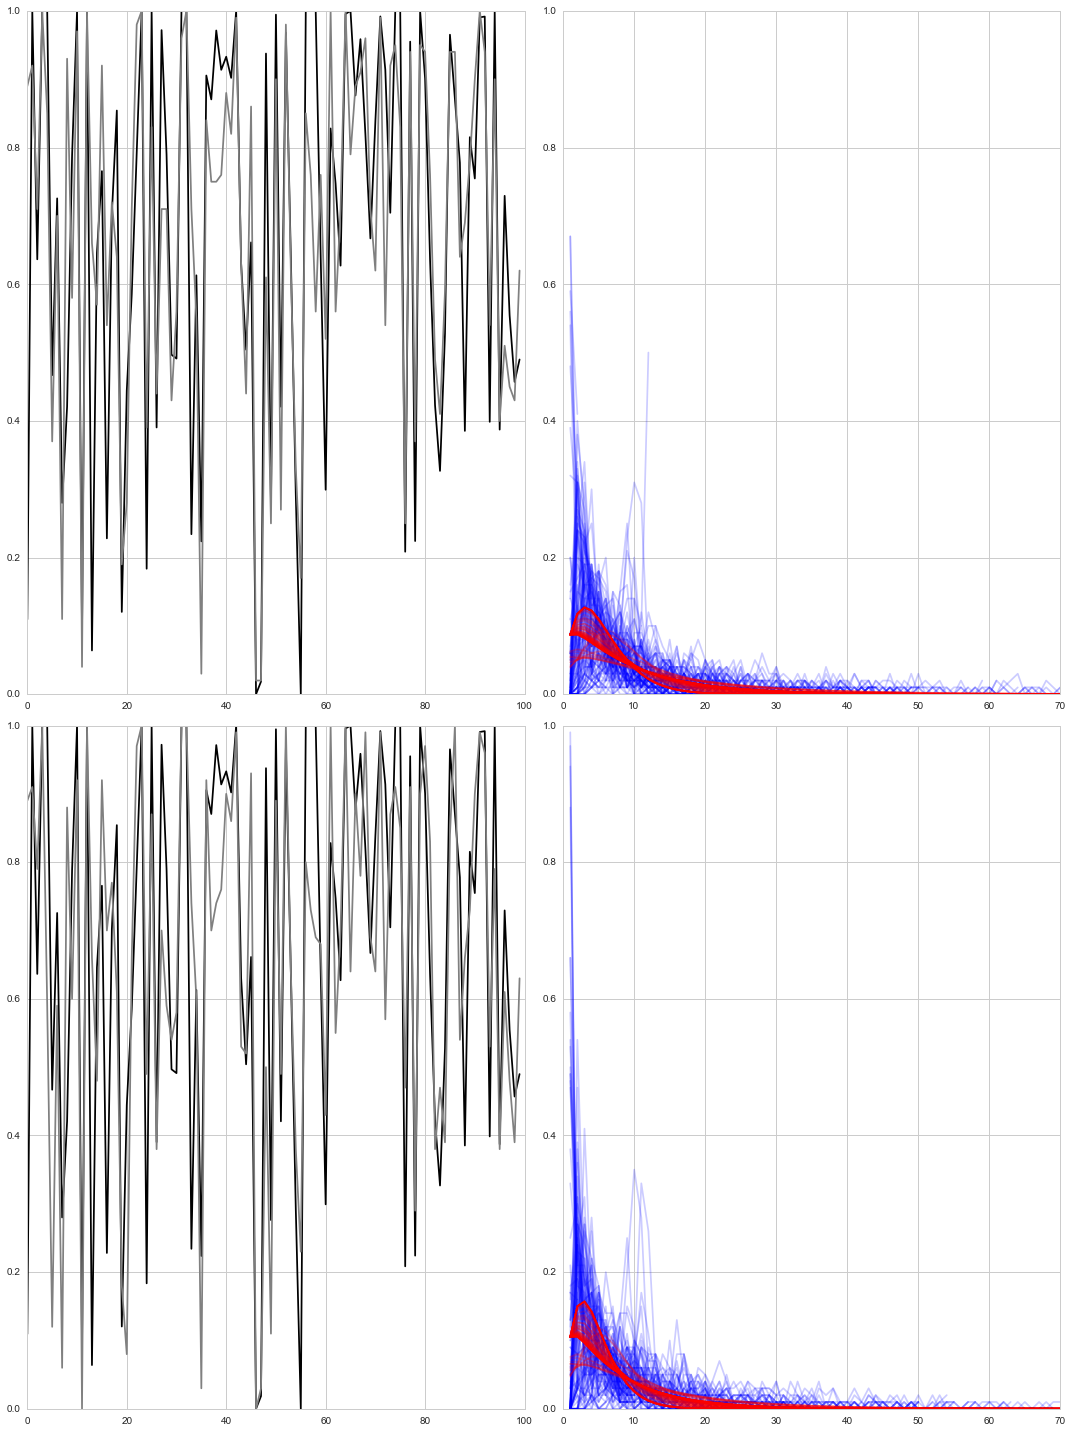

In [254]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], color='gray')
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

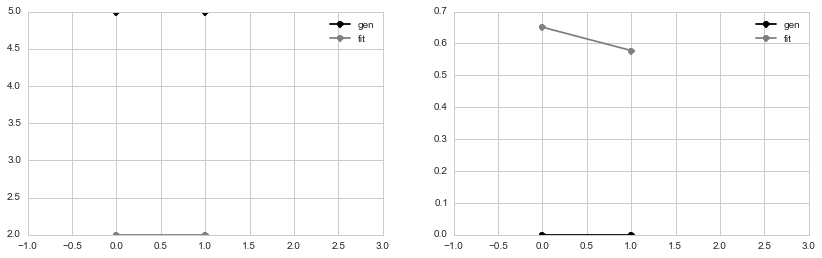

In [256]:
# recovered parameters
bf_par   = {'theta': [], 'p_stay': [], 'tau': []}
true_par = {'theta': [], 'p_stay': [], 'tau': []}

for gp in gen_pars:
    
    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    for par in ['theta', 'p_stay']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 2, figsize=(14,4))

for i, par in enumerate(['theta', 'p_stay']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()

## fit gamma

In [ ]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'p_stay', 'prelec_gamma'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

IndexError: too many indices for array

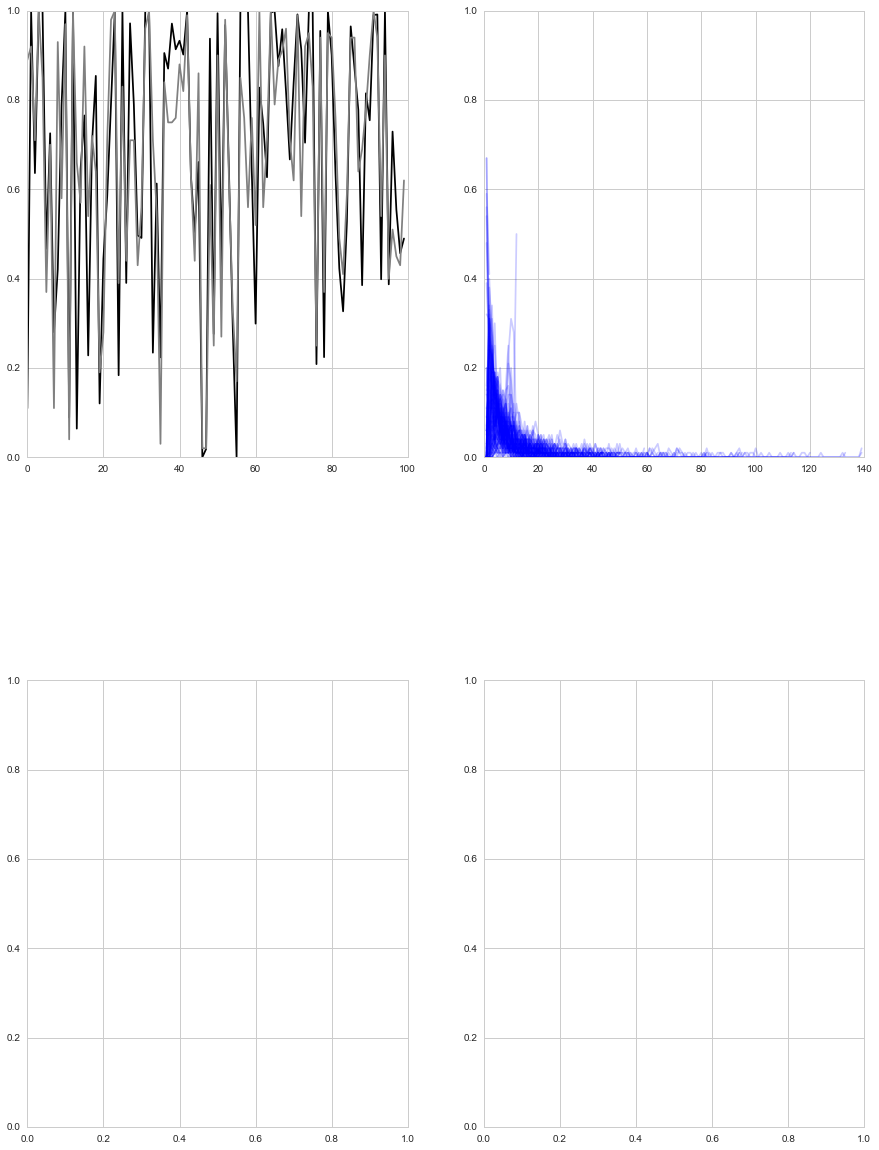

In [252]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], color='gray')
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

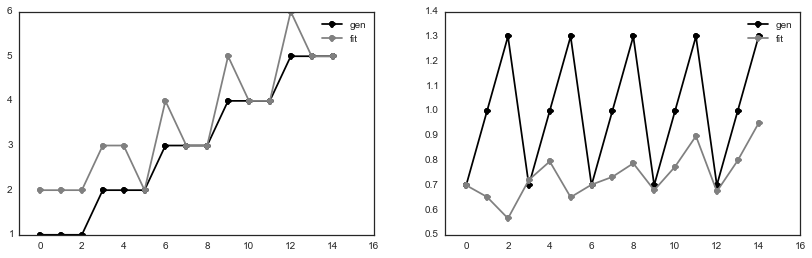

In [83]:
bf_par   = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}
true_par = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}

for gp in gen_pars:
    
    theta = gp['theta']
    #p_stay = gp['p_stay']
    p_stay = 0.
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    true_par['prelec_gamma'].append(gamma)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    #for par in ['theta', 'p_stay', 'tau', 'prelec_gamma']:
    for par in ['theta', 'prelec_gamma']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 2, figsize=(14,4))

#for i, par in enumerate(['theta', 'p_stay', 'tau', 'prelec_gamma']):
for i, par in enumerate(['theta', 'prelec_gamma']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()

## TPT

In [90]:
with open('/Users/markant/code/chase/chase/paper/data/tpt_problems.pkl', 'r') as f:
    problems = pickle.load(f)

In [91]:
cpt_fits_obj = {}
cpt_fits_exp = {}
chase_fits = {}
N_FIT_ITER = 1

In [92]:
N = 200  # N has to be low enough for sampling error to have an impact! 

gen_pars = []
for theta in [1, 2, 3, 4, 5]:
    for gamma in [.7, 1., 1.3]:
        for p_stay in [0.]:
        
            gen_pars.append({'N': N,
                             'theta': theta,
                             'p_stay': p_stay,
                             'prelec_gamma': gamma})
            
cols = ['theta', 'p_stay', 'gamma', 'subject', 'problem', 'problem-subject', 'group', 'choice', 'samplesize']
df = pd.DataFrame(columns=cols)

for gp in gen_pars:

    samplesize, choices, problems_exp = simulate_process(problems, gp, relfreq=True)
    print np.round([choices[pid].mean() for pid in problems], 3)

    data = []
    for pid in problems:
        arr = np.transpose(([gp['theta'] for _ in range(N)], 
                            [gp['p_stay'] for _ in range(N)],
                            [gp['prelec_gamma'] for _ in range(N)],
                            range(N), 
                            [pid for _ in range(N)], 
                            [('%s-%s' % (pid, i)) for i in range(N)],
                            np.zeros(N, int), 
                            np.array(choices[pid], int), np.array(samplesize[pid], int)))
        data.append(arr)
    data = pd.DataFrame(np.concatenate(data, axis=0), columns=cols)
    df = pd.concat((df, data))

df = df.convert_objects(convert_numeric=True)      



[ 0.41   0.46   0.46   0.505  0.49   0.47   0.63   0.51   0.485  0.31   0.56
  0.495  0.51   0.465  0.525  0.53   0.53   0.49   0.5    0.65   0.52
  0.545  0.575  0.485  0.47   0.565  0.455  0.585  0.485  0.66   0.55
  0.475  0.52   0.55   0.495  0.37   0.595  0.43   0.81   0.525  0.535
  0.495  0.48   0.52   0.545  0.49   0.505  0.465  0.64   0.525  0.455  0.7
  0.52   0.52   0.49   0.555  0.495  0.5    0.525  0.49 ]
[ 0.505  0.51   0.49   0.53   0.48   0.52   0.64   0.53   0.5    0.5    0.545
  0.51   0.515  0.48   0.475  0.465  0.515  0.5    0.51   0.61   0.595
  0.56   0.58   0.605  0.58   0.59   0.47   0.64   0.465  0.785  0.59
  0.465  0.52   0.555  0.595  0.44   0.61   0.44   0.75   0.51   0.5    0.545
  0.54   0.475  0.5    0.465  0.475  0.465  0.585  0.515  0.415  0.78
  0.515  0.52   0.54   0.54   0.405  0.47   0.5    0.53 ]
[ 0.545  0.505  0.485  0.48   0.48   0.56   0.595  0.53   0.52   0.54   0.47
  0.485  0.525  0.535  0.535  0.515  0.49   0.495  0.51   0.585  0.54   0.57

In [94]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'tau'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

{'theta': 1, 'prelec_gamma': 0.7, 'p_stay': 0.0, 'N': 200}
recover_process_data(tau,theta|)
0/10
['theta']: [ 1.]
iteration           0
success          True
nllh         77556.61
k                   2
N               12000
bic            155132
theta               1
tau               0.5
Name: 0, dtype: object
recover_process_data(tau,theta|)
1/10
['theta']: [ 2.]
iteration            0
success           True
nllh           25550.5
k                    2
N                12000
bic           51119.78
theta                2
tau          0.9999992
Name: 1, dtype: object
recover_process_data(tau,theta|)
2/10
['theta']: [ 3.]
iteration            0
success           True
nllh          30587.91
k                    2
N                12000
bic            61194.6
theta                3
tau          0.9999998
Name: 2, dtype: object
recover_process_data(tau,theta|)
3/10
['theta']: [ 4.]
iteration            0
success           True
nllh          34454.31
k                    2
N               

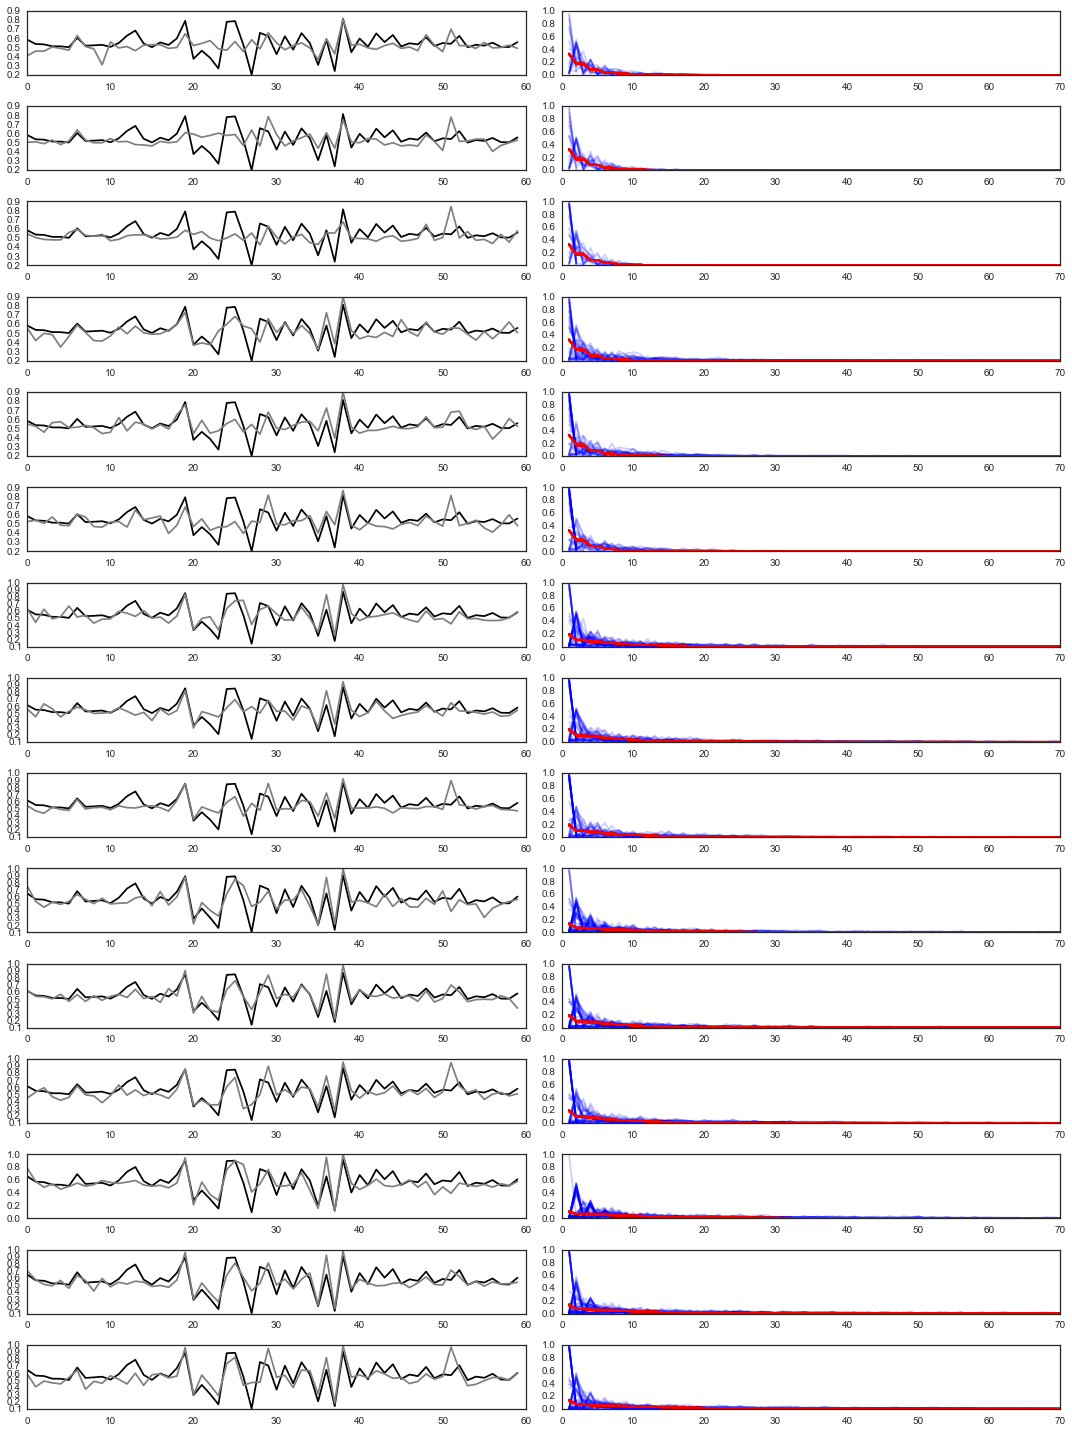

In [96]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], color='gray')
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

### fit gamma

In [97]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'prelec_gamma'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

{'theta': 1, 'prelec_gamma': 0.7, 'p_stay': 0.0, 'N': 200}
recover_process_data(prelec_gamma,theta|)
0/10
['theta']: [ 1.]
iteration               0
success              True
nllh             77556.02
k                       2
N                   12000
bic              155130.8
theta                   1
prelec_gamma    0.9689453
Name: 0, dtype: object
recover_process_data(prelec_gamma,theta|)
1/10
['theta']: [ 2.]
iteration              0
success             True
nllh            27418.38
k                      2
N                  12000
bic             54855.54
theta                  2
prelec_gamma     1.04375
Name: 1, dtype: object
recover_process_data(prelec_gamma,theta|)
2/10
['theta']: [ 3.]
iteration              0
success             True
nllh            36652.81
k                      2
N                  12000
bic              73324.4
theta                  3
prelec_gamma    1.066504
Name: 2, dtype: object
recover_process_data(prelec_gamma,theta|)
3/10
['theta']: [ 4.]
iteratio

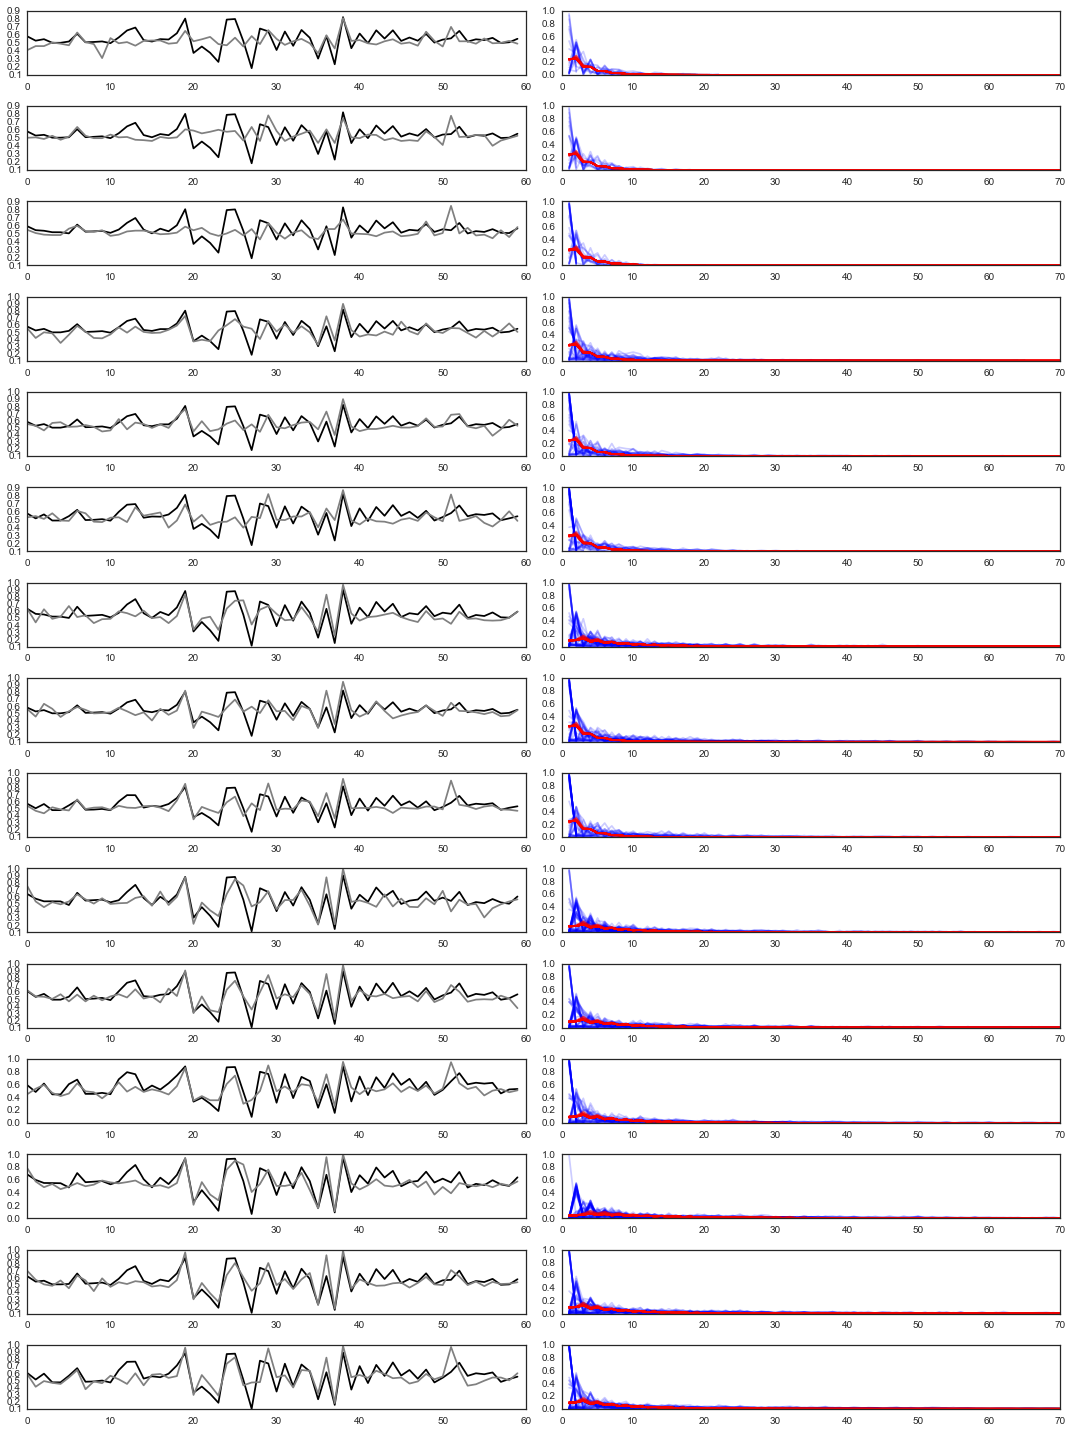

In [98]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], color='gray')
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

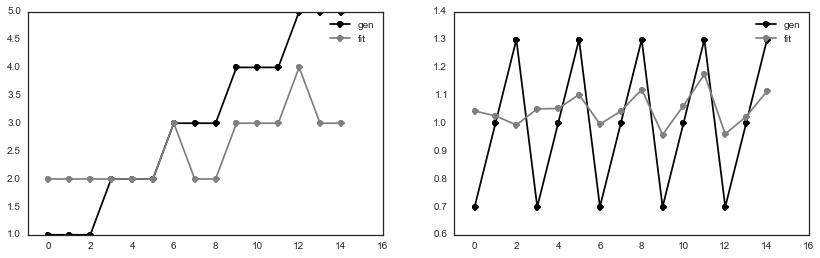

In [99]:
bf_par   = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}
true_par = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}

for gp in gen_pars:
    
    theta = gp['theta']
    #p_stay = gp['p_stay']
    p_stay = 0.
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    true_par['prelec_gamma'].append(gamma)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    #for par in ['theta', 'p_stay', 'tau', 'prelec_gamma']:
    for par in ['theta', 'prelec_gamma']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 2, figsize=(14,4))

#for i, par in enumerate(['theta', 'p_stay', 'tau', 'prelec_gamma']):
for i, par in enumerate(['theta', 'prelec_gamma']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()